# Introduction
We build and evaluate a systematic strategy to forecast NVDA’s overnight (close-to-open) returns using only information available at the prior US market close. The feature set captures market, sector, and peer-company signals, with economically motivated design choices and strict controls against data leakage. Using data from July 2023 to June 2025, we compare regularized linear baselines and non-linear models under a clear train/holdout split. Forecasts are translated into trading positions and evaluated out-of-sample against investable benchmarks, including buy-and-hold NVDA and the SOXX sector ETF.

# Featured Stocks

To motivate the peer universe, we also provide some brief references to recent news highlighting economic links between NVIDIA and several related companies, illustrating why some tickers are included in the feature set.

AMD, AVGO, GOOGL, MSFT, ORCL, TSM:
[How Sam Altman Tied Tech’s Biggest Players to OpenAI](https://www.wsj.com/tech/ai/sam-altman-open-ai-nvidia-deals-d10a6525)

ADBE, NOW, SAP, SNOW:
[Snowflake Teams with NVIDIA to Deliver Full-Stack AI Platform for Customers to Transform Their Industries](https://www.businesswire.com/news/home/20240318504019/en/Snowflake-Teams-with-NVIDIA-to-Deliver-Full-Stack-AI-Platform-for-Customers-to-Transform-Their-Industries)

DELL, HPE, SMCI:
[Dell Technologies Expands Dell AI Factory with NVIDIA to Turbocharge AI Adoption](https://www.dell.com/en-us/dt/corporate/newsroom/announcements/detailpage.press-releases~usa~2024~05~20240520-dell-technologies-expands-dell-ai-factory-with-nvidia-to-turbocharge-ai-adoption.htm#/filter-on/Country:en-us)

INTC:
[Investors Love Intel Again. That Still Doesn’t Solve Its Problems.](https://www.wsj.com/tech/investors-love-intel-again-that-still-doesnt-solve-its-problems-00d2dc0d)

AMZN:
[OpenAI, Amazon Sign $38 Billion Cloud Deal](https://www.wsj.com/tech/ai/openai-amazon-sign-38-billion-cloud-deal-89ff8650)

NOK:
[Nvidia to invest $1bn in Nokia as chip giant extends deal spree](https://on.ft.com/47MfGjm)

We further include a supplementary set of peer tickers chosen for economic relevance; we do not individually justify these selections.

AAPL, AKAM, AMAT, ANET, ASML, CAT, CRM, CSCO, DASTY, HNHPF, ILMN, IQV, JNJ, KLAC, LCID, LI, LLY, LNVGY, LOW, LRCX, MBGYY, META, MU, NIO, PLTR, RXRX, SIEGY, SOUN, STLA, T, TMUS, UBER, XPEV

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from pathlib import Path  # Added for results directory
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from arch import arch_model  # For GARCH
import warnings  # Added to suppress convergence warnings
from itertools import product  # Needed for ENet grid search

# Personal plot configuration
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Config and Globals

In [2]:
START = "2023-07-01"
END = "2025-06-30"

TARGET = "NVDA"

# fmt: off
PEERS = [
    # Cloud / AI infra
    "MSFT","GOOGL","AMZN","ORCL","AKAM","META","AAPL",
    # Telco
    "NOK","TMUS","T",
    # Auto / AV (US-traded lines incl. OTC ADRs)
    "UBER","STLA","LCID","MBGYY","LI","XPEV","NIO",
    # Hardware / systems
    "DELL","HPE","CSCO","SMCI","LNVGY",
    # Healthcare
    "JNJ","LLY","ILMN","IQV",
    # Software / manufacturing / twins adjacents
    "PLTR","LOW","SIEGY","TSM","HNHPF","CAT","DASTY",
    # Enterprise software
    "SNOW","NOW","SAP","ADBE","CRM","ANET",
    # Semis & equipment
    "AVGO","ASML","AMAT","KLAC","LRCX","MU",
    # Competitors
    "AMD","INTC",
    # NVDA direct investments
    "RXRX","SOUN",
]
# fmt: on

CTRL_TICKER = "SOXX"

ALL_TICKERS = sorted(set([TARGET] + PEERS + [CTRL_TICKER]))

# Load Data

In [3]:
# Our data loader.
from src.pipeline.loader import DataLoader

In [4]:
dl = DataLoader(
    tickers=ALL_TICKERS,
    start=START,
    end=END,
)

# Fetch and adjust data
dl.fetch_data().adjust_data()

# MultiIndex ["OHLCV-TR", "Ticker"], with level 0: ["open", "high", "low", "close", "volume", "total_return"]
# All prices and total_return as in Appendix B.
data_cube = dl.get_adjusted_data(source="true")

## Verify Data Load

In [5]:
# Generate needed verification dataframes as suggested in Appendix B.4
return_continuity, event_alignment = dl.verify_data("NVDA")

### Mean Absolute Difference of Returns by Ticker

- Left column: Yahoo with the manual computation using the correct dividend adjustment formula ('True')
- Right column: Yahoo with manual recomputation using Yahoo's approximated dividend adjustment formula ('Manual')."

In [6]:
return_continuity

,MAD Yahoo and True,MAD Yahoo and Manual Recomputation
Ticker,,
AAPL,8.559983e-08,6.019359e-08
ADBE,0.000000e+00,0.000000e+00
AKAM,0.000000e+00,0.000000e+00
AMAT,1.396971e-07,6.438130e-08
AMD,0.000000e+00,0.000000e+00
AMZN,0.000000e+00,0.000000e+00
ANET,0.000000e+00,0.000000e+00
ASML,1.494955e-07,6.548776e-08
AVGO,2.905229e-07,6.793946e-08


### Event Alignment

- Event date (dividend and split if available) including +- 1 day of event.
- Also displays formulas used for computation.
- We explicitly note again that f_split is all 1 because Yahoo data is split adjusted. This is **NOT** a mistake! See method `_fsplit` in `src/pipeline/loader.py` for details.

In [7]:
event_alignment

Ticker                NVDA                                              \
Diagnostics          Event Dividends f_div (True) f_div (Yahoo Approx)   
Date                                                                     
2023-09-05    pre-dividend     0.000     1.000000             1.000000   
2023-09-06     ex-dividend     0.004     0.999918             0.999918   
2023-09-07   post-dividend     0.000     1.000000             1.000000   
2024-06-07       pre-split     0.000     1.000000             1.000000   
2024-06-10           split     0.000     1.000000             1.000000   
2024-06-11      post-split     0.010     0.999918             0.999918   

Ticker                                                               \
Diagnostics Prod_{k > t} g_t (True) Prod_{k > t} g_t (Yahoo Approx)   
Date                                                                  
2023-09-05                 0.999385                        0.999385   
2023-09-06                 0.999467                        0.999467   
2023-09-07                 0.999467                        0.999467   
2024-06-07                 0.999602                        0.999602   
2024-06-10                 0.999602                        0.999602   
2024-06-11                 0.999684                        0.999684   

Ticker                                                                  \
Diagnostics Stock Splits f_split (1; All Yahoo Data is Split Adjusted)   
Date                                                                     
2023-09-05           0.0                                           1.0   
2023-09-06           0.0                                           1.0   
2023-09-07           0.0                                           1.0   
2024-06-07           0.0                                           1.0   
2024-06-10          10.0                                           1.0   
2024-06-11           0.0                                           1.0   

Ticker                                                \
Diagnostics Total Return (True) Total Return (Yahoo)   
Date                                                   
2023-09-05             0.000804             0.000804   
2023-09-06            -0.030550            -0.030550   
2023-09-07            -0.017424            -0.017424   
2024-06-07            -0.000909            -0.000909   
2024-06-10             0.007461             0.007461   
2024-06-11            -0.007144            -0.007144   

Ticker                                   
Diagnostics Total Return (Yahoo Manual)  
Date                                     
2023-09-05                     0.000804  
2023-09-06                    -0.030550  
2023-09-07                    -0.017424  
2024-06-07                    -0.000909  
2024-06-10                     0.007461  
2024-06-11                    -0.007144

# Add Features

In [8]:
# Our methods for feature engineering.
from src.pipeline.preprocess import (
    add_log_return,
    add_close_to_open_return,
    add_realized_annualized_volatility,
    add_momentum,
    add_liquidity,
)

In [9]:
# Note, each ticker has all the features.
# Think of this as a pipeline that is run once.
# Rerunning it will throw exceptions on purpose because the fields already exist.
data_cube = add_log_return(data_cube)  # Field: "log_return"
data_cube = add_close_to_open_return(data_cube)  # Field: "log_ret_co"
data_cube = add_realized_annualized_volatility(data_cube, days=5)  # Field: "vol5"
data_cube = add_momentum(data_cube, days=1)  # Field: "mom1"
data_cube = add_momentum(data_cube, days=5)  # Field: "mom5"
data_cube = add_liquidity(data_cube)  # Field: "log_dvol"

# Build Feature Matrix and Label Vector

In [10]:
# Some helpers that allowed us merge up and downstream code more easily.
from src.merge_helpers import _col, flatten_columns

In [11]:
# Additional globals.
LABEL_COL = "y_nvda_co"
FEATURES = ["log_return", "vol5", "mom1", "mom5", "log_dvol"]

In [12]:
# Label: TARGET (NVDA) close -> open; renaming to work with downstream; copy to avoid aliasing.
y_dirty = (
    data_cube["log_ret_co"][[TARGET]].rename(columns={TARGET: LABEL_COL}, copy=True).rename_axis("Features", axis=1)
)
y = y_dirty.dropna()

X_raw = flatten_columns(data_cube[FEATURES])
# Drop dates (index) in X that were also dropped in y.
X = X_raw.loc[y.index]

X_y = X.join(y)

# Metric and Evaluation Helpers

In [13]:
# Step 3: Configuration for Rolling Window Backtest
FEATURE_COLS = [c for c in X_y.columns if c != LABEL_COL]  # use ALL features

# Train/Validation/Test window length (time-based using pandas DateOffset)
TRAIN_OFFSET = pd.DateOffset(months=12)  # ~1 year
VAL_OFFSET = pd.DateOffset(months=6)  # ~6 months
TEST_OFFSET = pd.DateOffset(months=6)  # ~6 months # Length of the final reporting period
PREDICT_STEP = pd.DateOffset(days=1)  # Predict one day at a time in the test set

# Hyperparameter grid for alpha (Ridge)
ALPHA_GRID = np.logspace(-4, 2, 13)

# Cost config (Account for trading costs for buying and selling, arbitarily set for now)
COST_BPS = 0  # No longer used but keep for compatibility
ONE_WAY = 0.0  # zero cost so PnL is purely signal * y_real

# Step 3.5 - Results registry to store model outputs consistently
RESULTS_DIR = Path("reports")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Each "model_df" is an indexed-by-date DataFrame with at least columns: ["y_hat","y_real","signal","signal_prev","cost","pnl"]
results_store = {}  # dict[str, pd.DataFrame] keyed by model name
results_summary = None  # pd.DataFrame summary table


def register_results(name: str, df: pd.DataFrame):
    """Register a model's walk-forward result; persists to CSV."""
    if df is None or df.empty:
        print(f"[WARN] No results DataFrame provided for {name}. Skipping registration.")
        return
    assert {"y_real", "pnl"}.issubset(df.columns), f"{name} missing required columns 'y_real', 'pnl'"
    results_store[name] = df.copy()
    df_out = df.copy()
    # Save results to CSV file
    try:
        df_out.to_csv(RESULTS_DIR / f"{name}_wf.csv", index=True)
        print(f"[INFO] Results for {name} saved to {RESULTS_DIR / f'{name}_wf.csv'}")
    except Exception as e:
        print(f"[ERROR] Failed to save results for {name} to CSV: {e}")


def ann_stats(returns: pd.Series, periods_per_year=252):
    """Calculates annualized return, volatility, and Sharpe ratio."""
    r = returns.dropna()
    if r.empty:
        return {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
    mu = r.mean() * periods_per_year
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    shp = mu / vol if vol > 1e-9 else (0 if mu == 0 else np.sign(mu) * np.inf)  # Handle zero vol
    return {"ann_ret": mu, "ann_vol": vol, "sharpe": shp}


def summarize_results(results_store: dict) -> pd.DataFrame:
    """Creates a summary table of performance metrics for all registered models."""
    rows = []
    for name, df in results_store.items():
        if df is None or df.empty:
            continue  # Skip if no results

        net = ann_stats(df["pnl"])
        # Ensure y_real exists before calculating BH stats
        bh = (
            ann_stats(df["y_real"])
            if "y_real" in df.columns
            else {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
        )

        # Calculate turnover and exposure if signal columns exist
        turn = np.nan
        expo = pd.Series(dtype=float)
        if {"signal", "signal_prev"}.issubset(df.columns):
            turn = (df["signal"] - df["signal_prev"].fillna(0)).abs().mean()
            expo = df["signal"].value_counts(normalize=True)

        rows.append(
            {
                "model": name,
                **{f"net_{k}": v for k, v in net.items()},
                **{f"bh_{k}": v for k, v in bh.items()},  # Baseline is buy&hold of the target leg (e.g., C->O or C->C)
                "turnover_legs_per_day": float(turn),
                "pct_long": float(expo.get(1, 0.0)),
                "pct_short": float(expo.get(-1, 0.0)),
                # Calculate pct_flat ensuring it sums to 1 even if signal has NaNs
                "pct_flat": max(0.0, 1.0 - expo.get(1, 0.0) - expo.get(-1, 0.0)),
            }
        )

    if not rows:
        print("[WARN] No results found in results_store to summarize.")
        return pd.DataFrame()

    out = pd.DataFrame(rows).set_index("model").sort_values("net_sharpe", ascending=False)
    # Save summary to CSV
    try:
        out.to_csv(RESULTS_DIR / "model_summary.csv")
        print(f"[INFO] Model summary saved to {RESULTS_DIR / 'model_summary.csv'}")
    except Exception as e:
        print(f"[ERROR] Failed to save model summary to CSV: {e}")
    return out

# Models and Validation

In [14]:
# Merge helper.
from src.merge_helpers import check_df_empty

In [15]:
# Some more globals. These were also introduced to merge the code logic.
CTRL_COL = _col(CTRL_TICKER, "log_return")
LOG_RETURN_COLS = [col for col in X_y.columns if "log_return" in col]
PEERS_ALL = [col for col in LOG_RETURN_COLS if (CTRL_TICKER not in col) or (TARGET not in col)]
USE_PEERS = PEERS_ALL

## Model 1: Ridge Regression

In [16]:
# --- Residualization helpers: calculate_betas() and apply_resid_slice() ---
def calculate_betas(train_df_raw: pd.DataFrame, feature_cols, ctrl_col: str, peers_list=PEERS_ALL):
    """
    Estimate a single slope beta for each peer vs the control factor on the TRAIN set.
    Returns: dict {peer -> beta}.

    Notes:
    - Matches the later code that prints a single number per peer (no intercept stored).
    - Uses de-meaned series to get a stable slope; falls back to 0.0 if insufficient data.
    """
    betas = {}
    if ctrl_col not in train_df_raw.columns:
        raise KeyError(f"Control column '{ctrl_col}' not found in training data.")

    ctrl = train_df_raw[ctrl_col]

    # De-mean control once for numerical stability
    x = (ctrl - ctrl.mean()).to_frame(name=ctrl_col)

    for p in peers_list:
        # Skip the control – we never residualize it on itself
        if p == ctrl_col:
            betas[p] = np.nan
            continue

        if p not in feature_cols or p not in train_df_raw.columns:
            continue

        y_raw = train_df_raw[p].astype(float)
        df = pd.concat([x, (y_raw - y_raw.mean()).rename(p)], axis=1).dropna()
        if check_df_empty(df):
            betas[p] = 0.0
            continue

        # Closed-form slope on demeaned data: beta = cov(x,y) / var(x)
        x_dm = df[ctrl_col].values
        y_dm = df[p].values
        denom = (x_dm**2).sum()
        if denom <= 0:
            betas[p] = 0.0
        else:
            betas[p] = float((x_dm * y_dm).sum() / denom)

    return betas


def apply_resid_slice(df_slice: pd.DataFrame, betas: dict, feature_cols, ctrl_col: str, peers_list):
    if ctrl_col not in df_slice.columns:
        raise KeyError(f"Control column '{ctrl_col}' not found in the slice.")

    out_cols = {}
    if ctrl_col in feature_cols:
        out_cols[ctrl_col] = df_slice[ctrl_col].astype(float)

    ctrl_vals = df_slice[ctrl_col].astype(float)

    # --- DEBUG tracking ---
    residualized_peers = []
    skipped_peers = []

    for p in peers_list:
        # Never residualize the control itself
        if p == ctrl_col:
            continue

        if p in df_slice.columns:
            b = betas.get(p, 0.0)
            peer_vals = df_slice[p].astype(float)
            out_cols[f"{p}_res"] = peer_vals - b * ctrl_vals
            residualized_peers.append(p)
        else:
            skipped_peers.append(p)

    # --- DEBUG prints ---
    print(f"[INFO] apply_resid_slice: residualized peers ({len(residualized_peers)}): {residualized_peers}")
    if skipped_peers:
        print(f"[INFO] apply_resid_slice: peers missing from slice and NOT residualized: {skipped_peers}")

    if not out_cols:
        cols = [ctrl_col] if ctrl_col in feature_cols else []
        cols += [f"{p}_res" for p in peers_list]
        return pd.DataFrame(index=df_slice.index, columns=cols, dtype=float)

    return pd.DataFrame(out_cols, index=df_slice.index)


# -----------------------------
# Ridge (FixedFWD, Resid) block
# -----------------------------
def _alpha_grid_fallback():
    # Prefer a Ridge-specific grid if present; otherwise fall back cleanly.
    if "ALPHA_GRID_RIDGE" in globals():
        return globals()["ALPHA_GRID_RIDGE"]
    if "ALPHA_GRID" in globals():
        return globals()["ALPHA_GRID"]
    return np.logspace(-4, 2, 13)  # sane default


def _best_alpha_by_val(X_train_res, y_train, X_val_res, y_val, alphas=None):
    """
    Simple forward validation:
      - Fit a Ridge model for each alpha on TRAIN (residualized features).
      - Pick alpha with the lowest MSE on VALIDATION.
      - Refit a new model on combined (TRAIN + VALIDATION) using that alpha.
    Returns: best_alpha, final_pipeline, common_features_used
    """
    if alphas is None:
        alphas = _alpha_grid_fallback()

    best_alpha, best_mse = None, np.inf

    # Common features between train and val
    common_features = X_train_res.columns.intersection(X_val_res.columns).tolist()
    if not common_features:
        print("[WARN] No common features between residualized train and validation sets.")
        return 1.0, None, []

    # ---- 1) Validation loop to select alpha ----
    train_fit_df = X_train_res[common_features].join(y_train).dropna()
    val_fit_df = X_val_res[common_features].join(y_val).dropna()
    if check_df_empty(train_fit_df) or check_df_empty(val_fit_df):
        print("[ERROR] Empty TRAIN or VAL after NaN drop in _best_alpha_by_val.")
        return 1.0, None, common_features

    Xtr_fit, ytr_fit = train_fit_df[common_features], train_fit_df[y_train.name]
    Xva_fit, yva_fit = val_fit_df[common_features], val_fit_df[y_val.name]

    for a in alphas:
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("ridge", Ridge(alpha=a, fit_intercept=True, random_state=42)),
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)  # scaler fit ONLY on train
            y_pred_val = pipe.predict(Xva_fit)  # transform val using train scaler
            mse = mean_squared_error(yva_fit, y_pred_val)
            if mse < best_mse:
                best_mse, best_alpha = mse, a
        except Exception as e:
            print(f"[WARN] Ridge fit failed for alpha={a}: {e}")

    if best_alpha is None:
        print("[WARN] No best alpha found. Defaulting to 1.0")
        best_alpha = 1.0

    # ---- 2) Refit on (Train + Val) ----
    X_tv_res = pd.concat([X_train_res, X_val_res], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)

    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", Ridge(alpha=best_alpha, fit_intercept=True, random_state=42)),
        ]
    )

    final_fit_df = X_tv_res.join(y_tv).dropna()
    if check_df_empty(final_fit_df):
        print("[ERROR] Combined Train+Val residualized data empty. Cannot fit final model.")
        return best_alpha, None, common_features

    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[y_tv.name])
    except Exception as e:
        print(f"[ERROR] Final Ridge fit failed with alpha={best_alpha}: {e}")
        return best_alpha, None, common_features

    return best_alpha, final_pipe, common_features


def ridge_fixedfwd_resid_eval(
    X_y: pd.DataFrame,
    feature_cols=FEATURE_COLS,  # raw feature cols in X_y
    label_col=LABEL_COL,
    ctrl_col=CTRL_COL,
    peers_list=USE_PEERS,  # peers for residualization
    train_offset=TRAIN_OFFSET,
    val_offset=VAL_OFFSET,
    test_offset=TEST_OFFSET,
    cost_one_way=ONE_WAY,
    alphas=None,
):
    """
    Fixed Forward Validation (aligns with other models):
      - Use one fixed Train / Val / Test split.
      - Residualize once using betas from TRAIN.
      - Tune alpha on Train→Val, refit on Train+Val, evaluate on Test.
      - Returns a DataFrame indexed by test dates with columns:
            ['y_hat','y_real','alpha','signal','signal_prev','cost','pnl']
    """
    # ---- 0) Build fixed splits (same logic as others) ----
    dates = X_y.index
    first_train_start = dates.min()
    train_end_date = first_train_start + train_offset - pd.Timedelta(days=1)
    val_end_date = train_end_date + val_offset
    test_end_date = val_end_date + test_offset

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   to {val_df_raw.index.max().date()}   ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  to {test_df_raw.index.max().date()}  ({len(test_df_raw)} days)"
    )

    if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")

    # ---- 1) Residualization betas from TRAIN and apply to all splits ----
    print("[INFO] Calculating residualization betas on fixed training set (Ridge)...")
    betas_fixed_ridge = calculate_betas(train_df_raw, feature_cols, ctrl_col, peers_list)

    print("[INFO] Applying residualization to Train/Val/Test (Ridge)...")
    X_train_res = apply_resid_slice(train_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)
    X_val_res = apply_resid_slice(val_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)
    X_test_res = apply_resid_slice(test_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)

    # Final residualized feature names (ctrl + peers_res) to keep consistent ordering
    resid_feature_cols = []
    if ctrl_col in feature_cols:
        resid_feature_cols.append(ctrl_col)
        resid_feature_cols += [p + "_res" for p in peers_list if p != ctrl_col]

    # bring in style features if present
    exclude_for_style = set([ctrl_col, label_col]) | set(peers_list)
    style_cols = [c for c in feature_cols if (c in train_df_raw.columns) and (c not in exclude_for_style)]

    # build FULL design matrices = [residualized peers (+ctrl)] ⨁ [style features]
    X_train_full = pd.concat([X_train_res[resid_feature_cols], train_df_raw[style_cols]], axis=1)
    X_val_full = pd.concat([X_val_res[resid_feature_cols], val_df_raw[style_cols]], axis=1)
    X_test_full = pd.concat([X_test_res[resid_feature_cols], test_df_raw[style_cols]], axis=1)

    # --- inspect design matrix ---
    print(f"[INFO] Residualized feature columns (ctrl + peers_res): {resid_feature_cols}")
    print(f"[INFO] Style feature columns: {style_cols}")
    print(f"[INFO] X_train_full columns ({len(X_train_full.columns)} total):")
    print(list(X_train_full.columns))

    # Targets
    y_train = train_df_raw[label_col]
    y_val = val_df_raw[label_col]
    y_test = test_df_raw[label_col]

    # ---- 2) Tune alpha on Train→Val, then refit on Train+Val ----
    best_alpha, final_model, common_features = _best_alpha_by_val(
        X_train_full, y_train, X_val_full, y_val, alphas=alphas
    )
    if final_model is None:
        print("[ERROR] Final Ridge model could not be trained. Returning empty results.")
        return pd.DataFrame(columns=["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"])

    print(f"[INFO] Best Ridge alpha (FixedFWD): {best_alpha:.6f}")

    # Determine the exact feature order the model expects
    try:
        model_features = list(final_model.feature_names_in_)  # sklearn >= 1.0
    except AttributeError:
        model_features = list(common_features)  # fallback

    # --- Inspect Ridge feature usage ---
    try:
        ridge_step = final_model.named_steps["ridge"]
        coef_series = pd.Series(ridge_step.coef_, index=model_features).astype(float)

        # Save to a global so you can inspect later in the notebook
        global RIDGE_FEATURE_COEFS
        RIDGE_FEATURE_COEFS = coef_series

        # Print a concise summary
        print(f"[INFO] Ridge model trained on {len(model_features)} features.")
        print("[INFO] Top 15 Ridge coefficients by |value|:")
        coef_sorted = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)
        print(coef_sorted.head(15))
    except Exception as e:
        print(f"[WARN] Could not extract Ridge coefficients: {e}")

    # ---- 3) Predict on TEST and compute PnL ----
    X_test_predict = X_test_full.reindex(columns=model_features)
    test_pred_df = X_test_predict.join(y_test.rename("y_real")).dropna()
    if check_df_empty(test_pred_df):
        print("[WARN] No valid rows in TEST after NaN drop. Returning empty results.")
        return pd.DataFrame(columns=["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"])

    # Predictions
    y_hat_test = pd.Series(final_model.predict(test_pred_df[model_features]), index=test_pred_df.index, name="y_hat")

    out = test_pred_df[["y_real"]].copy()
    out["y_hat"] = y_hat_test
    out["alpha"] = best_alpha
    out["signal"] = np.where(out["y_hat"] > 0, 1, np.where(out["y_hat"] < 0, -1, 0))
    out["signal_prev"] = out["signal"].shift(1).fillna(0)
    legs = (out["signal_prev"] - out["signal_prev"].shift(1).fillna(0)).abs()
    out["cost"] = legs * cost_one_way
    out["pnl"] = out["signal_prev"] * out["y_real"] - out["cost"]

    out = out[["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"]]
    out.index.name = "date"
    return out


# Execute the FixedFWD evaluation for Ridge and register with unified key
print("\n" + "=" * 50)
print("Executing Ridge (FixedFWD, Residualized Features)")
print("=" * 50)
ridge_fixedfwd_resid_df = ridge_fixedfwd_resid_eval(X_y)
print("\n[INFO] Ridge_FixedFWD_Resid (head of results):")
if not check_df_empty(ridge_fixedfwd_resid_df):
    print(ridge_fixedfwd_resid_df.head())
else:
    print("[INFO] No results generated.")
print("=" * 50)

# Register the results with the same naming convention as other models
register_results("Ridge_FixedFWD_Resid", ridge_fixedfwd_resid_df)


Executing Ridge (FixedFWD, Residualized Features)
[INFO] Fixed Splits | Train: 2023-07-05 to 2024-07-03 (252 days)
[INFO] Fixed Splits | Val  : 2024-07-05   to 2025-01-03   (127 days)
[INFO] Fixed Splits | Test : 2025-01-06  to 2025-06-26  (118 days)
[INFO] Calculating residualization betas on fixed training set (Ridge)...
[INFO] Applying residualization to Train/Val/Test (Ridge)...
[INFO] apply_resid_slice: residualized peers (50): ['AAPL_log_return', 'ADBE_log_return', 'AKAM_log_return', 'AMAT_log_return', 'AMD_log_return', 'AMZN_log_return', 'ANET_log_return', 'ASML_log_return', 'AVGO_log_return', 'CAT_log_return', 'CRM_log_return', 'CSCO_log_return', 'DASTY_log_return', 'DELL_log_return', 'GOOGL_log_return', 'HNHPF_log_return', 'HPE_log_return', 'ILMN_log_return', 'INTC_log_return', 'IQV_log_return', 'JNJ_log_return', 'KLAC_log_return', 'LCID_log_return', 'LI_log_return', 'LLY_log_return', 'LNVGY_log_return', 'LOW_log_return', 'LRCX_log_return', 'MBGYY_log_return', 'META_log_retur


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.5349       0.4184      1.2784     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.6186    0.7542   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid     0.2458    0.0000  
[INFO] Plot saved to reports/cumulative_pnl_comparison_no_dupe_benchmarks.png


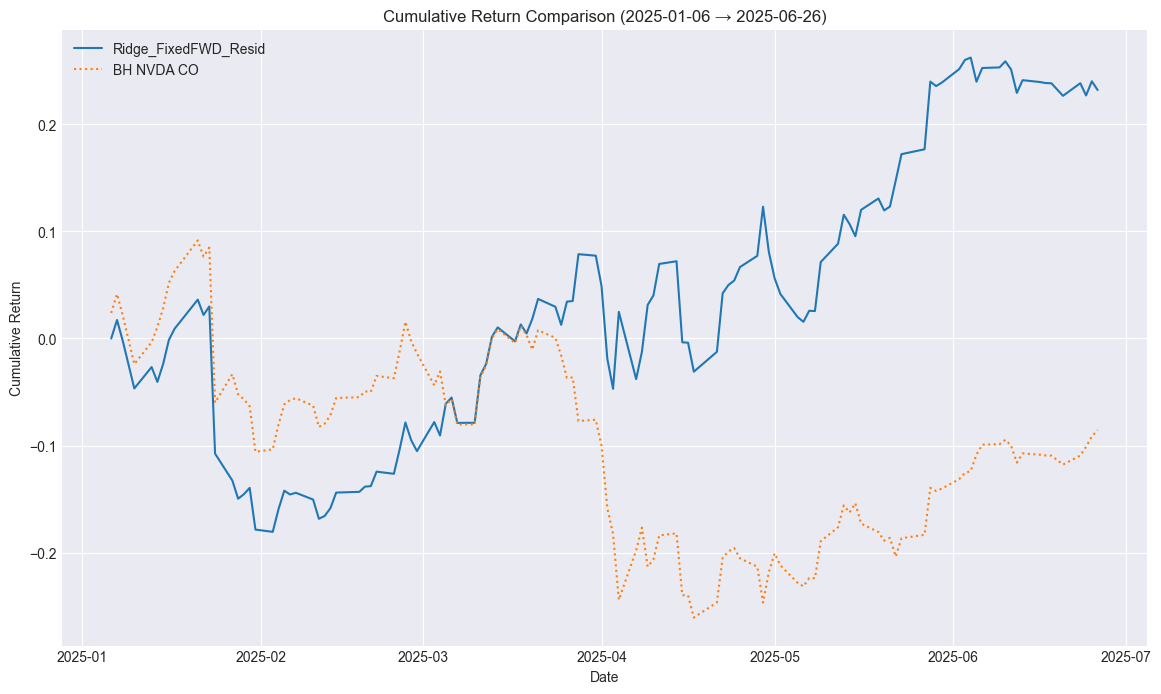

[INFO] Ridge_FixedFWD_Resid best alpha (FixedFWD): 100


In [17]:
# ==================================
# Step 6: Evaluation and Plotting
# ==================================

# --- 1. Print the Summary Statistics Table ---
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
# Use summarize_results function
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    # Use pandas context to format the print output
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- 2. Generate Cumulative PnL Plot ---
# Only proceed if there are results in the registry
if results_store:
    plt.figure(figsize=(14, 8))  # Create the plot figure
    plot_count = 0  # Counter to see if we plotted anything

    # 2a) Plot all strategy curves first
    ret_windows = []  # Store (start, end) dates for each strategy
    for name, df in results_store.items():
        # Check for valid data
        if df is not None and not df.empty and "pnl" in df.columns:
            # Calculate cumulative PnL if it doesn't exist
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1

            curve = df["cum_pnl"].dropna()  # Get the PnL curve

            if not curve.empty:
                # Plot the strategy's PnL curve
                plt.plot(curve.index, curve.values, label=f"{name}")
                plot_count += 1
                # Save the start and end date of this curve
                ret_windows.append((curve.index.min(), curve.index.max()))

    if plot_count == 0:
        print("[INFO] No strategy returns to plot.")
        plt.close()  # Close the empty figure
    else:
        # 2b) Build a COMMON window (intersection) for benchmarks. We find the latest start date and the earliest end date, and this gives the time window
        # where *all* strategies were active
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)

        if common_start >= common_end:
            print("[WARN] No overlapping window across models; benchmarks skipped.")
        else:
            # --- Plot Benchmarks on the Common Window ---

            # --- BH NVDA CO (from any CO-model's y_real), once ---
            co_series = None
            # Find the first model that has 'y_real' (our CO return)
            for name, df in results_store.items():
                if df is not None and not df.empty and "y_real" in df.columns:
                    s = df["y_real"].dropna()
                    # Slice the 'y_real' series to the common window
                    s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                    if len(s) > 0:
                        co_series = s
                        break  # Found it, stop looping

            if co_series is not None and len(co_series) > 0:
                # Calculate and plot the cumulative CO return
                bh_co = (1 + co_series).cumprod() - 1
                plt.plot(bh_co.index, bh_co.values, linestyle=":", label="BH NVDA CO")

            # --- BH NVDA CC (from adj_close), once ---
            # Assumes 'adj_close' DataFrame exists in memory
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
                px = adj_close["NVDA"].dropna().sort_index()
                # Slice the price series to the common window
                px = px.loc[(px.index >= common_start) & (px.index <= common_end)]
                if len(px) >= 2:
                    # Use indexing (like SOXX) for a consistent start point
                    # This calculates (Price_t / Price_0) - 1
                    bh_cc = (px / px.iloc[0]) - 1.0
                    plt.plot(bh_cc.index, bh_cc.values, linestyle="--", label="BH NVDA CC")

            # --- SOXX CC (indexed), once ---
            # Assumes 'adj_close' DataFrame exists in memory
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
                soxx = adj_close["SOXX"].dropna().sort_index()
                # Slice the price series to the common window
                soxx = soxx.loc[(soxx.index >= common_start) & (soxx.index <= common_end)]
                if len(soxx) >= 2:
                    # Calculate and plot the indexed SOXX return
                    # (Price_t / Price_0) - 1
                    soxx_norm = (soxx / soxx.iloc[0]) - 1.0
                    plt.plot(soxx_norm.index, soxx_norm.values, label="SOXX CC (indexed)")

        # 3) Finish and save the plot
        plt.title(f"Cumulative Return Comparison ({common_start.date()} → {common_end.date()})")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            # Save plot to RESULTS_DIR
            out = RESULTS_DIR / "cumulative_pnl_comparison_no_dupe_benchmarks.png"
            if "SAVE_AT_END" in globals() and SAVE_AT_END:
                # Defer saving until the end to keep outputs written once
                print(f"[INFO] Deferred saving plot to {out} (SAVE_AT_END=True).")
            else:
                plt.savefig(out)
                print(f"[INFO] Plot saved to {out}")
        except Exception as e:
            print(f"[ERROR] Saving plot failed: {e}")
        plt.show()  # Display the plot

        # --- 4. Print specific model info (e.g., Ridge alpha) ---
        if "Ridge_FixedFWD_Resid" in results_store:
            ridge_df = results_store["Ridge_FixedFWD_Resid"]
            if "alpha" in ridge_df.columns and not ridge_df["alpha"].dropna().empty:
                alpha_val = ridge_df["alpha"].dropna().iloc[0]
                print(f"[INFO] Ridge_FixedFWD_Resid best alpha (FixedFWD): {alpha_val:.6g}")
            else:
                print("[INFO] Alpha column not available or empty for Ridge model.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

In evaluating the performance of our daily trading strategies, we utilize specific Buy-and-Hold (BH) benchmarks designed to directly correspond to the strategies' intended holding periods, rather than a simple long-term investment "buy and hold forever" approach. This decision allows for a fairer assessment of the timing value added by the models, instead of comparing it to some investment.

The benchmarks used are: BH NVDA CO (Close-to-Open), which represents the return achieved by passively buying NVDA stock at the market close each day and selling it at the market open the following day, aligning with strategies targeting overnight movements. By comparing our strategies against this interval-specific benchmarks, we can better isolate whether our models' signals generated alpha beyond simply holding the asset during the targeted trading windows.

### Model 2: Lasso Models

In [18]:
# Hyperparameter grids
ALPHA_GRID_RIDGE = np.logspace(-4, 2, 13)  # Alpha for Ridge
ALPHA_GRID_LASSO = np.logspace(-5, -1, 13)  # Alpha for Lasso (typically needs smaller values)
ALPHA_GRID_ENET = np.logspace(-5, -1, 13)  # Alpha for ElasticNet
L1_RATIO_GRID_ENET = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # L1 ratio for ElasticNet

In [19]:
# ============================================
# Lasso (FixedFWD, Residualized Features)
# Reuses calculate_betas / apply_resid_slice from Ridge block above
# ============================================
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

print("\n" + "=" * 50)
print("Executing Lasso Backtest with Fixed Forward Validation (Residualized)")
print("=" * 50)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# -------------------------------------------------
# 1. Fixed Train / Val / Test splits (same as Ridge)
# -------------------------------------------------
if "train_df_raw" in locals() and "val_df_raw" in locals() and "test_df_raw" in locals():
    print("[INFO] Re-using existing Train/Val/Test splits for Lasso.")
else:
    dates = X_y.index
    first_train_start = dates.min()

    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

print(
    f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
)
print(
    f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()} to {val_df_raw.index.max().date()} ({len(val_df_raw)} days)"
)
print(
    f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()} to {test_df_raw.index.max().date()} ({len(test_df_raw)} days)"
)

if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
    raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")

# -------------------------------------------------
# 2. Residualization betas from TRAIN (shared helper)
# -------------------------------------------------
print("[INFO] Calculating residualization betas on fixed TRAIN set (Lasso, shared with Ridge)...")
betas_fixed_lasso = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, peers_list=USE_PEERS)

print("[INFO] Betas (sample):")
for k in list(betas_fixed_lasso.keys())[:10]:
    print(f"    {k}: {betas_fixed_lasso[k]:.4f}")
print(f"[INFO] Total peers with betas: {len(betas_fixed_lasso)}")

# -------------------------------------------------
# 3. Apply residualization to Train / Val / Test
# -------------------------------------------------
print("[INFO] Applying residualization to Train/Val/Test for Lasso (shared apply_resid_slice)...")
X_train_res = apply_resid_slice(train_df_raw, betas_fixed_lasso, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed_lasso, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed_lasso, FEATURE_COLS, CTRL_COL, USE_PEERS)

# Which peers actually got residualized? (look for *_res cols that exist)
resid_cols_train = [c for c in X_train_res.columns if c.endswith("_res")]
print(f"[INFO] Residualized peer-return columns in X_train_res ({len(resid_cols_train)}):")
print(resid_cols_train)
print(f"[INFO] Control column present in X_train_res: {CTRL_COL in X_train_res.columns}")

# -------------------------------------------------
# 3b. Build full feature set: residualized returns + ALL other features
# -------------------------------------------------
#  - residualized returns: CTRL_COL (raw) + p_res for each peer actually present
resid_feature_cols = []
if CTRL_COL in X_train_res.columns:
    resid_feature_cols.append(CTRL_COL)
resid_feature_cols += [f"{p}_res" for p in USE_PEERS if f"{p}_res" in X_train_res.columns]

#  - other features: everything in FEATURE_COLS that is NOT in USE_PEERS and NOT the control
#    (these are your vol/mom/dvol etc. for all tickers)
other_feature_cols = [
    c for c in FEATURE_COLS if (c not in USE_PEERS) and (c != CTRL_COL) and (c in train_df_raw.columns)
]

print(f"[INFO] Non-return / style features included ({len(other_feature_cols)}):")
print(other_feature_cols)

# Final design matrices
X_train_full = pd.concat([X_train_res[resid_feature_cols], train_df_raw[other_feature_cols]], axis=1)
X_val_full = pd.concat([X_val_res[resid_feature_cols], val_df_raw[other_feature_cols]], axis=1)
X_test_full = pd.concat([X_test_res[resid_feature_cols], test_df_raw[other_feature_cols]], axis=1)

print(f"[INFO] X_train_full columns ({len(X_train_full.columns)} total):")
print(list(X_train_full.columns))

# Targets
y_train = train_df_raw[LABEL_COL]
y_val = val_df_raw[LABEL_COL]
y_test = test_df_raw[LABEL_COL]


# -------------------------------------------------
# 4. Tune Alpha via fixed Train -> Val, then refit on Train+Val
# -------------------------------------------------
def _best_alpha_by_val_lasso_fixed(X_train_full, y_train, X_val_full, y_val, alphas=ALPHA_GRID_LASSO):
    best_alpha, best_mse = None, np.inf

    common_features = X_train_full.columns.intersection(X_val_full.columns).tolist()
    if not common_features:
        print("[ERROR] No common features between train and val for Lasso.")
        return 1e-3, None, []

    # Build clean TRAIN set (drop all-NaN cols, then rows with any NaN)
    train_fit_df = X_train_full[common_features].join(y_train).dropna(axis=1, how="all").dropna(axis=0, how="any")
    common_features = [c for c in common_features if c in train_fit_df.columns]

    if check_df_empty(train_fit_df) or not common_features:
        print("[ERROR] Lasso Tuning: Training data empty after NaN drop.")
        return 1e-3, None, []

    Xtr_fit = train_fit_df[common_features]
    ytr_fit = train_fit_df[LABEL_COL]

    # Clean VAL set
    val_pred_df = X_val_full[common_features].join(y_val).dropna()
    if check_df_empty(val_pred_df):
        print("[WARN] Lasso Tuning: Validation data empty after NaN drop.")
        Xva_pred = pd.DataFrame(columns=common_features, index=[])
        yva_eval = pd.Series(name=LABEL_COL, dtype=float)
    else:
        Xva_pred = val_pred_df[common_features]
        yva_eval = val_pred_df[LABEL_COL]

    # Validation loop
    for a in alphas:
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("lasso", Lasso(alpha=a, random_state=42, max_iter=2000)),
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)
            if not Xva_pred.empty:
                y_pred_val = pipe.predict(Xva_pred)
                mse = mean_squared_error(yva_eval, y_pred_val)
                if mse < best_mse:
                    best_mse, best_alpha = mse, a
            else:
                best_alpha = a
        except ValueError as e:
            print(f"[WARN] Lasso pipe fitting failed for alpha={a}: {e}")
            continue

    if best_alpha is None:
        best_alpha = 1e-3
        print("[WARN] No best alpha found for Lasso. Defaulting to 1e-3.")

    # Refit on TRAIN+VAL
    X_tv_full = pd.concat([X_train_full, X_val_full], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)

    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("lasso", Lasso(alpha=best_alpha, random_state=42, max_iter=2000)),
        ]
    )

    final_fit_df = X_tv_full.join(y_tv).dropna()
    if check_df_empty(final_fit_df):
        print("[ERROR] Lasso final fit data empty.")
        return best_alpha, None, common_features

    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[LABEL_COL])
    except ValueError as e:
        print(f"[ERROR] Lasso final pipe fitting failed: {e}")
        return best_alpha, None, common_features

    return best_alpha, final_pipe, common_features


print("\n[INFO] Tuning Lasso alpha using fixed validation set...")
best_alpha_lasso, final_model_lasso, lasso_features_used = _best_alpha_by_val_lasso_fixed(
    X_train_full, y_train, X_val_full, y_val
)

print(f"[INFO] Lasso common feature set size: {len(lasso_features_used)}")

# -------------------------------------------------
# 5. Test Final Model + extract selected features
# -------------------------------------------------
# Initialise globals so they always exist
LASSO_SELECTED_FEATURES = []
selected_features_lasso = []

if final_model_lasso is None:
    print("[ERROR] Final Lasso model could not be trained. Skipping testing.")
    wf_lasso_fixed_res = pd.DataFrame()
else:
    print(f"[INFO] Best Lasso Alpha: {best_alpha_lasso:.5f}")
    print("[INFO] Evaluating final Lasso model on fixed TEST set...")

    try:
        model_features = list(final_model_lasso.feature_names_in_)
    except AttributeError:
        model_features = lasso_features_used

    # Make sure TEST has those columns
    X_test_pred = X_test_full.reindex(columns=model_features).dropna()

    if check_df_empty(X_test_pred):
        print("[WARN] No valid data points in TEST after dropping NaNs.")
        wf_lasso_fixed_res = pd.DataFrame()
    else:
        y_hat_test_array = final_model_lasso.predict(X_test_pred)
        y_hat_test = pd.Series(y_hat_test_array, index=X_test_pred.index)

        test_results_df = pd.DataFrame({"y_hat": y_hat_test}).join(y_test.rename("y_real")).dropna()

        if check_df_empty(test_results_df):
            print("[WARN] No common dates between test predictions and actuals.")
            wf_lasso_fixed_res = pd.DataFrame()
        else:
            # Trading logic: use previous day's signal for PnL
            test_results_df["signal"] = np.where(
                test_results_df["y_hat"] > 0, 1, np.where(test_results_df["y_hat"] < 0, -1, 0)
            )
            test_results_df["signal_prev"] = test_results_df["signal"].shift(1).fillna(0)
            test_results_df["delta_pos"] = (test_results_df["signal"] - test_results_df["signal_prev"]).abs()
            test_results_df["cost"] = test_results_df["delta_pos"] * ONE_WAY
            test_results_df["pnl"] = (
                test_results_df["signal_prev"] * test_results_df["y_real"] - test_results_df["cost"]
            )
            test_results_df["hyperparam"] = best_alpha_lasso

            wf_lasso_fixed_res = test_results_df.copy()

    # --- Extract non-zero coefficient features for GARCH downstream ---
    try:
        lasso_step = final_model_lasso.named_steps["lasso"]
        coef_series = pd.Series(lasso_step.coef_, index=model_features).astype(float)
        LASSO_SELECTED_FEATURES = coef_series[~np.isclose(coef_series.values, 0.0, atol=1e-8)].index.tolist()
        selected_features_lasso = list(LASSO_SELECTED_FEATURES)

        print(f"[INFO] Lasso kept {len(LASSO_SELECTED_FEATURES)} non-zero features:")
        print(LASSO_SELECTED_FEATURES)
    except Exception as e:
        print(f"[WARN] Could not extract Lasso feature importances: {e}")
        LASSO_SELECTED_FEATURES = []
        selected_features_lasso = []

# -------------------------------------------------
# 6. Register results
# -------------------------------------------------
register_results("Lasso_FixedFWD_Resid", wf_lasso_fixed_res)

if not check_df_empty(wf_lasso_fixed_res):
    print("\n[INFO] wf_lasso_fixed_res (head of test results):")
    print(wf_lasso_fixed_res.head())
else:
    print("[INFO] No results generated for Lasso Fixed FWD.")
print("=" * 50)


Executing Lasso Backtest with Fixed Forward Validation (Residualized)
[INFO] Fixed Splits | Train: 2023-07-05 to 2024-07-03 (252 days)
[INFO] Fixed Splits | Val  : 2024-07-05 to 2025-01-03 (127 days)
[INFO] Fixed Splits | Test : 2025-01-06 to 2025-06-26 (118 days)
[INFO] Calculating residualization betas on fixed TRAIN set (Lasso, shared with Ridge)...
[INFO] Betas (sample):
    AAPL_log_return: 0.3189
    ADBE_log_return: 0.4908
    AKAM_log_return: 0.2000
    AMAT_log_return: 1.0191
    AMD_log_return: 1.2410
    AMZN_log_return: 0.4799
    ANET_log_return: 0.7815
    ASML_log_return: 1.0053
    AVGO_log_return: 1.0666
    CAT_log_return: 0.3520
[INFO] Total peers with betas: 51
[INFO] Applying residualization to Train/Val/Test for Lasso (shared apply_resid_slice)...
[INFO] apply_resid_slice: residualized peers (50): ['AAPL_log_return', 'ADBE_log_return', 'AKAM_log_return', 'AMAT_log_return', 'AMD_log_return', 'AMZN_log_return', 'ANET_log_return', 'ASML_log_return', 'AVGO_log_return

In [20]:
# Needed below
adj_close = data_cube["close"]


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.5349       0.4184      1.2784     -0.1006   
Lasso_FixedFWD_Resid      -0.1515       0.4197     -0.3609     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.6186    0.7542   
Lasso_FixedFWD_Resid      0.4212    -0.2389                 0.0085    1.0000   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid     0.2458    0.0000  
Lasso_FixedFWD_Resid     0.0000    0.0000  
[INFO] Plot saved to reports/cumulative_pnl_comparison_no_dupe_benchmarks.png


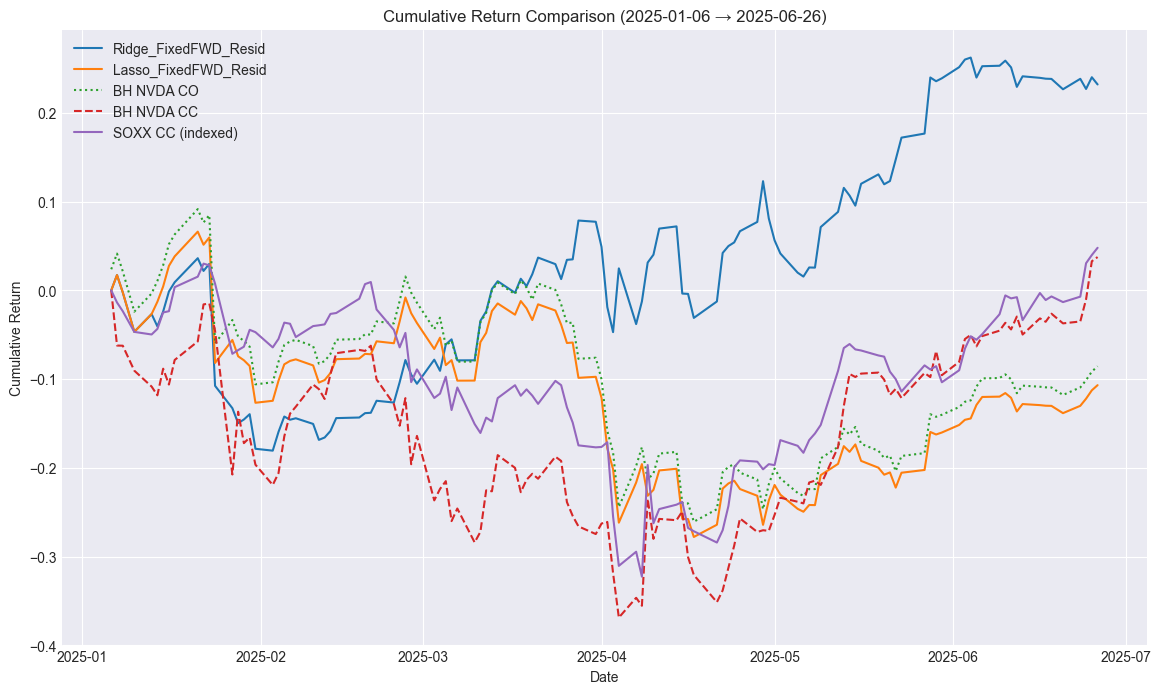

[INFO] Lasso hyperparameter plot saved to reports/Lasso_FixedFWD_Resid_hyperparam_test_period.png


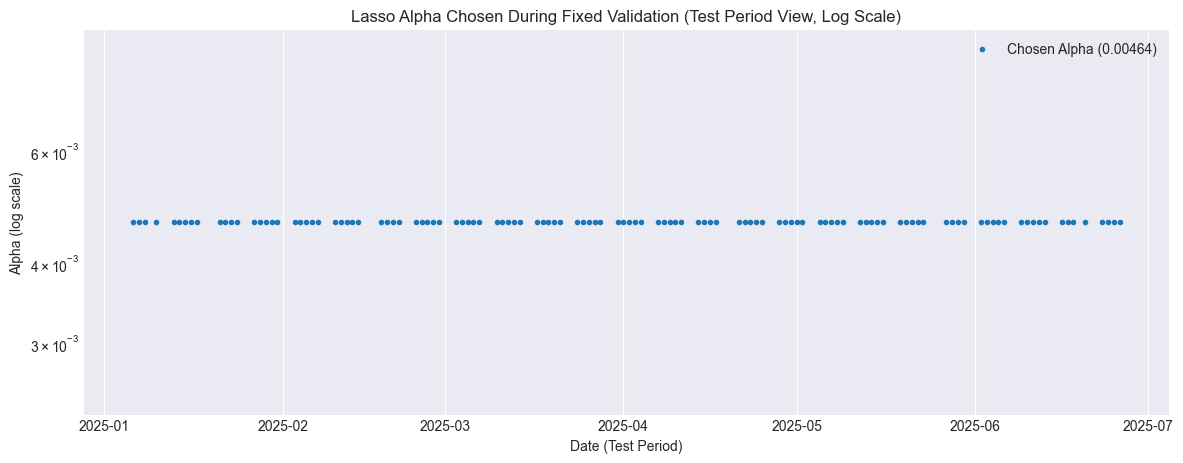

In [21]:
# Step 6: Evaluation (Using the results registry functions), and plotting results

# Summarize results from the store
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0
    ret_windows = []

    # (1) Plot strategy cumulative returns and record active windows
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1
            curve = df["cum_pnl"].dropna()
            if not curve.empty:
                plt.plot(curve.index, curve.values, label=f"{name}")
                plot_count += 1
                ret_windows.append((curve.index.min(), curve.index.max()))
            else:
                print(f"[INFO] Skipping plot for {name} - cumulative PnL is all NaN.")

    if plot_count == 0:
        print("[INFO] No strategy returns to plot.")
        plt.close()
    else:
        # (2) Build COMMON window (intersection) for benchmarks
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)

        if common_start >= common_end:
            print("[WARN] No overlapping window across models; benchmarks skipped.")
        else:
            # --- Benchmarks on the common window ---

            # (a) BH NVDA CO from any model df that carries y_real
            co_series = None
            for name, df in results_store.items():
                if df is not None and not df.empty and "y_real" in df.columns:
                    s = df["y_real"].dropna()
                    s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                    if len(s) > 0:
                        co_series = s
                        break
            if co_series is not None and len(co_series) > 0:
                bh_co = (1 + co_series).cumprod() - 1
                plt.plot(bh_co.index, bh_co.values, linestyle=":", label="BH NVDA CO")

            # (b) BH NVDA CC from adj_close
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
                px = adj_close["NVDA"].dropna().sort_index()
                px = px.loc[(px.index >= common_start) & (px.index <= common_end)]
                if len(px) >= 2:
                    bh_cc = (px / px.iloc[0]) - 1.0
                    plt.plot(bh_cc.index, bh_cc.values, linestyle="--", label="BH NVDA CC")

            # (c) SOXX CC indexed
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
                soxx = adj_close["SOXX"].dropna().sort_index()
                soxx = soxx.loc[(soxx.index >= common_start) & (soxx.index <= common_end)]
                if len(soxx) >= 2:
                    soxx_norm = (soxx / soxx.iloc[0]) - 1.0
                    plt.plot(soxx_norm.index, soxx_norm.values, label="SOXX CC (indexed)")

        # (3) Finish and save the plot — use the SAME filename as before
        PLOT_NAME = "cumulative_pnl_comparison_no_dupe_benchmarks.png"
        try:
            title_str = (
                f"Cumulative Return Comparison ({common_start.date()} → {common_end.date()})"
                if "common_start" in locals() and "common_end" in locals() and common_start < common_end
                else "Cumulative Return Comparison"
            )
            plt.title(title_str)
        except Exception:
            plt.title("Cumulative Return Comparison")

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            out = RESULTS_DIR / PLOT_NAME
            plt.savefig(out)
            print(f"[INFO] Plot saved to {out}")
        except Exception as e:
            print(f"[ERROR] Failed to save plot: {e}")
        plt.show()

    # --- LASSO hyperparameter plot (if available) ---
    lasso_model_key = "Lasso_FixedFWD_Resid"
    if lasso_model_key in results_store:
        lasso_df = results_store[lasso_model_key]
        if "hyperparam" in lasso_df.columns and not lasso_df["hyperparam"].isna().all():
            plt.figure(figsize=(14, 5))
            plt.scatter(
                lasso_df.index,
                lasso_df["hyperparam"],
                marker=".",
                label=f'Chosen Alpha ({lasso_df["hyperparam"].iloc[0]:.5f})',
            )
            plt.yscale("log")
            plt.title("Lasso Alpha Chosen During Fixed Validation (Test Period View, Log Scale)")
            plt.xlabel("Date (Test Period)")
            plt.ylabel("Alpha (log scale)")
            min_alpha = lasso_df["hyperparam"].min()
            max_alpha = lasso_df["hyperparam"].max()
            if min_alpha == max_alpha and min_alpha > 0:
                plt.ylim(min_alpha * 0.5, max_alpha * 2)
            plt.legend()
            plt.grid(True)
            try:
                plot_filename = f"{lasso_model_key}_hyperparam_test_period.png"
                plt.savefig(RESULTS_DIR / plot_filename)
                print(f"[INFO] Lasso hyperparameter plot saved to {RESULTS_DIR / plot_filename}")
            except Exception as e:
                print(f"[ERROR] Failed to save hyperparameter plot for {lasso_model_key}: {e}")
            plt.show()
        else:
            print(f"[INFO] Hyperparameter column ('hyperparam') not available or empty for {lasso_model_key}.")
    else:
        print(f"[INFO] Results for {lasso_model_key} not found in results_store.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

### Model 3: Elastic Net

In [22]:
# ============================================
# Elastic Net (FixedFWD, Residualized Features)
# ============================================
# Assumes the following already exist in the notebook:
#   - X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, USE_PEERS
#   - TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET
#   - ALPHA_GRID_ENET, L1_RATIO_GRID_ENET
#   - ONE_WAY, check_df_empty, register_results
#   - calculate_betas, apply_resid_slice  (Ridge-style helpers)
#
# And Ridge / Lasso blocks above are using the same helpers.

from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

print("\n" + "=" * 50)
print("Executing Elastic Net (FixedFWD, Residualized Features)")
print("=" * 50)

# --- 1. Fixed time splits (reuse if already defined) ---
if "train_df_raw" not in locals() or "val_df_raw" not in locals() or "test_df_raw" not in locals():
    print("[INFO] Redefining fixed time splits for Elastic Net...")
    dates = X_y.index
    first_train_start = dates.min()

    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   to {val_df_raw.index.max().date()}   ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  to {test_df_raw.index.max().date()}  ({len(test_df_raw)} days)"
    )

    if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")
else:
    print("[INFO] Using existing fixed time splits (from Ridge/Lasso).")

# --- 2. Residualization betas on TRAIN (reuse if available) ---
if "betas_fixed" not in locals():
    print("[INFO] Calculating residualization betas on fixed TRAIN set for ENet...")
    betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)
    print(f"[INFO] Betas calculated: {{ {', '.join(f'{k}: {v:.4f}' for k, v in betas_fixed.items())} }}")
else:
    print("[INFO] Using existing fixed betas (shared with Ridge/Lasso).")

# --- 3. Apply residualization and build FULL design matrices ---
print("[INFO] Applying residualization to Train / Val / Test for ENet...")
X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

# Residualized base features: same pattern as Ridge/Lasso
resid_feature_cols = []
# raw control factor (SOXX_log_return), NOT residualized
if CTRL_COL in X_train_res.columns:
    resid_feature_cols.append(CTRL_COL)

# only include residuals that actually exist in X_train_res
resid_feature_cols += [f"{p}_res" for p in USE_PEERS if f"{p}_res" in X_train_res.columns]

print(f"[INFO] ENet residualized base features ({len(resid_feature_cols)}): {resid_feature_cols}")

# Dynamic style features
core_peer_set = set(USE_PEERS) | {CTRL_COL}
style_candidates = [c for c in FEATURE_COLS if (c not in core_peer_set) and (c != LABEL_COL)]

# Keep only those actually present in the raw frame
style_cols = [c for c in style_candidates if c in train_df_raw.columns]

print(f"[INFO] ENet style features added ({len(style_cols)}): {style_cols}")

# FULL design matrices = [residualized peers (+ctrl)] ⨁ [style features]
X_train_full = pd.concat([X_train_res[resid_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[resid_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[resid_feature_cols], test_df_raw[style_cols]], axis=1)

print(f"[INFO] ENet X_train_full has {X_train_full.shape[1]} columns.")
print(f"[INFO] ENet X_train_full columns: {list(X_train_full.columns)}")

# Targets
y_train = train_df_raw[LABEL_COL]
y_val = val_df_raw[LABEL_COL]
y_test = test_df_raw[LABEL_COL]


# --- 4. Tune Alpha and L1-ratio via fixed Train→Val ---
def _best_params_by_val_enet_fixed(
    X_train_full, y_train, X_val_full, y_val, alphas=ALPHA_GRID_ENET, l1_ratios=L1_RATIO_GRID_ENET
):
    best_alpha, best_l1, best_mse = None, None, np.inf

    common_features = X_train_full.columns.intersection(X_val_full.columns).tolist()
    if not common_features:
        print("[WARN] ENet: no common features between TRAIN and VAL.")
        return (1e-3, 0.5), None

    # Drop all-NaN columns on TRAIN, then any rows with NaNs
    train_fit_df = (
        X_train_full[common_features].join(y_train.to_frame()).dropna(axis=1, how="all").dropna(axis=0, how="any")
    )
    common_features = [f for f in common_features if f in train_fit_df.columns]

    if check_df_empty(train_fit_df) or not common_features:
        print("[ERROR] ENet Tuning: Training data empty after NaN drop.")
        return (1e-3, 0.5), None

    Xtr_fit = train_fit_df[common_features]
    ytr_fit = train_fit_df[LABEL_COL]

    # Validation data
    val_pred_df = X_val_full[common_features].join(y_val).dropna()
    if check_df_empty(val_pred_df):
        print("[WARN] ENet Tuning: Validation data empty after NaN drop.")
        Xva_pred = pd.DataFrame(columns=common_features, index=[])
        yva_eval = pd.Series(name=LABEL_COL, dtype=float)
    else:
        Xva_pred = val_pred_df[common_features]
        yva_eval = val_pred_df[LABEL_COL]

    for a, l1 in product(alphas, l1_ratios):
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("enet", ElasticNet(alpha=a, l1_ratio=l1, random_state=42, max_iter=2000)),
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)
            if not Xva_pred.empty:
                y_pred_val = pipe.predict(Xva_pred)
                mse = mean_squared_error(yva_eval, y_pred_val)
                if mse < best_mse:
                    best_mse, best_alpha, best_l1 = mse, a, l1
            else:
                best_alpha, best_l1 = a, l1
        except ValueError as e:
            print(f"[WARN] ENet pipe fitting failed for alpha={a}, l1={l1}: {e}")
            continue

    if best_alpha is None:
        best_alpha, best_l1 = 1e-3, 0.5
        print("[WARN] No best params found for ENet. Defaulting.")

    # Refit on TRAIN+VAL with the pruned feature set
    X_tv_full = pd.concat([X_train_full, X_val_full], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)

    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("enet", ElasticNet(alpha=best_alpha, l1_ratio=best_l1, random_state=42, max_iter=2000)),
        ]
    )

    final_fit_df = X_tv_full.join(y_tv).dropna()
    if check_df_empty(final_fit_df):
        print("[ERROR] ENet final fit data empty.")
        return (best_alpha, best_l1), None

    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[LABEL_COL])
    except ValueError as e:
        print(f"[ERROR] ENet final pipe fitting failed: {e}")
        return (best_alpha, best_l1), None

    return (best_alpha, best_l1), final_pipe


print("\n[INFO] Tuning Elastic Net params using fixed validation set...")
best_params_enet, final_model_enet = _best_params_by_val_enet_fixed(X_train_full, y_train, X_val_full, y_val)

# --- 5. Test Final Model ---
if final_model_enet is None:
    print("[ERROR] Final Elastic Net model could not be trained. Skipping testing.")
    wf_enet_fixed_res = pd.DataFrame()
else:
    best_alpha_enet, best_l1_enet = best_params_enet
    print(f"[INFO] Best ENet Alpha: {best_alpha_enet:.5f}, Best L1 Ratio: {best_l1_enet:.2f}")
    print("[INFO] Evaluating final Elastic Net model on fixed TEST set...")

    try:
        model_features = list(final_model_enet.feature_names_in_)
    except AttributeError:
        model_features = X_train_full.columns.tolist()

    X_test_pred = X_test_full[model_features].dropna()
    if check_df_empty(X_test_pred):
        print("[WARN] No valid data points in the TEST set after dropping NaNs.")
        wf_enet_fixed_res = pd.DataFrame()
    else:
        y_hat_test_array = final_model_enet.predict(X_test_pred)
        y_hat_test = pd.Series(y_hat_test_array, index=X_test_pred.index)

        test_results_df = pd.DataFrame({"y_hat": y_hat_test}).join(y_test.rename("y_real")).dropna()

        if check_df_empty(test_results_df):
            print("[WARN] No common dates between TEST predictions and actuals.")
            wf_enet_fixed_res = pd.DataFrame()
        else:
            test_results_df["signal"] = np.where(
                test_results_df["y_hat"] > 0, 1, np.where(test_results_df["y_hat"] < 0, -1, 0)
            )
            test_results_df["signal_prev"] = test_results_df["signal"].shift(1).fillna(0)
            test_results_df["delta_pos"] = (test_results_df["signal"] - test_results_df["signal_prev"]).abs()
            test_results_df["cost"] = test_results_df["delta_pos"] * ONE_WAY
            test_results_df["pnl"] = (
                test_results_df["signal_prev"] * test_results_df["y_real"] - test_results_df["cost"]
            )
            test_results_df["hyperparam"] = [(best_alpha_enet, best_l1_enet)] * len(test_results_df)

            wf_enet_fixed_res = test_results_df.copy()

# --- 6. Register Results ---
register_results("ENet_FixedFWD_Resid", wf_enet_fixed_res)

if not check_df_empty(wf_enet_fixed_res):
    print("\n[INFO] wf_enet_fixed_res (head of TEST results):")
    print(wf_enet_fixed_res.head())
else:
    print("[INFO] No results generated for Elastic Net Fixed FWD.")
print("=" * 50)


Executing Elastic Net (FixedFWD, Residualized Features)
[INFO] Using existing fixed time splits (from Ridge/Lasso).
[INFO] Calculating residualization betas on fixed TRAIN set for ENet...
[INFO] Betas calculated: { AAPL_log_return: 0.3189, ADBE_log_return: 0.4908, AKAM_log_return: 0.2000, AMAT_log_return: 1.0191, AMD_log_return: 1.2410, AMZN_log_return: 0.4799, ANET_log_return: 0.7815, ASML_log_return: 1.0053, AVGO_log_return: 1.0666, CAT_log_return: 0.3520, CRM_log_return: 0.4423, CSCO_log_return: 0.1530, DASTY_log_return: 0.3145, DELL_log_return: 0.7756, GOOGL_log_return: 0.3800, HNHPF_log_return: 0.2620, HPE_log_return: 0.5130, ILMN_log_return: 0.3751, INTC_log_return: 0.7614, IQV_log_return: 0.3665, JNJ_log_return: -0.0893, KLAC_log_return: 1.0611, LCID_log_return: 0.4674, LI_log_return: 0.3575, LLY_log_return: 0.1086, LNVGY_log_return: 0.4017, LOW_log_return: 0.2857, LRCX_log_return: 1.0492, MBGYY_log_return: 0.2666, META_log_return: 0.5679, MSFT_log_return: 0.3647, MU_log_return


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.5349       0.4184      1.2784     -0.1006   
Lasso_FixedFWD_Resid      -0.1515       0.4197     -0.3609     -0.1006   
ENet_FixedFWD_Resid       -0.1515       0.4197     -0.3609     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.6186    0.7542   
Lasso_FixedFWD_Resid      0.4212    -0.2389                 0.0085    1.0000   
ENet_FixedFWD_Resid       0.4212    -0.2389                 0.0085    1.0000   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid   

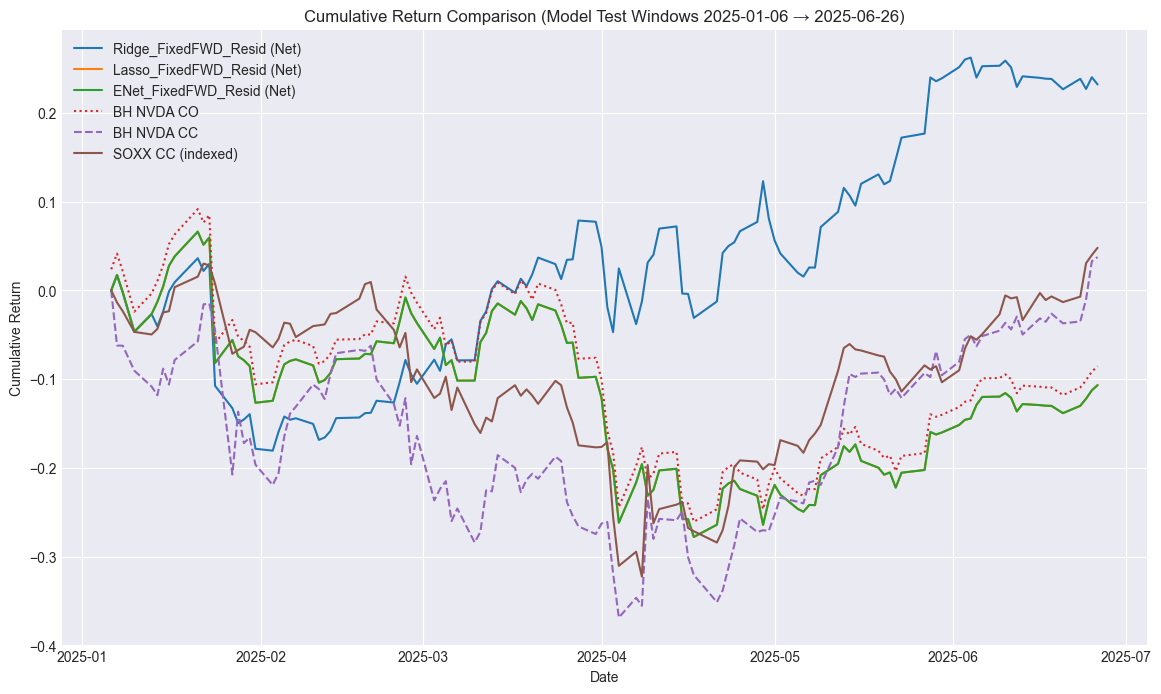

[INFO] Elastic Net hyperparameter plot saved to reports/ENet_FixedFWD_Resid_hyperparams_test_period.png


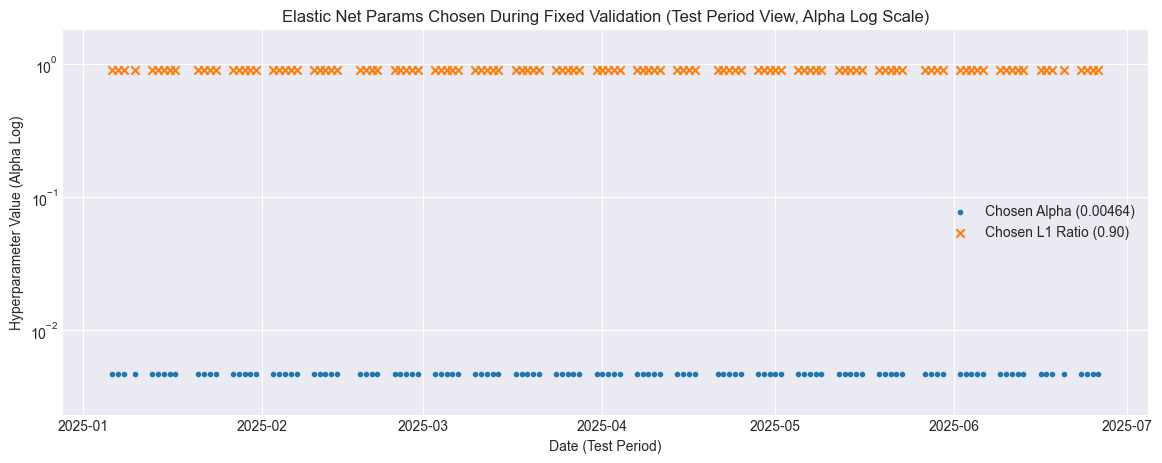

In [23]:
# Summarize results from the store
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
# Assuming summarize_results function is defined in a previous cell
# It should already handle saving the summary to CSV.
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    # Display more precision in the summary table
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
# Plot only models present in the results_store
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # Collect overall plotting window from model results
    all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
    all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]
    start_dt = min(all_min_dates) if all_min_dates else None
    end_dt = max(all_max_dates) if all_max_dates else None

    # Plot strategy cumulative returns
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            # Add cumulative PnL column if needed
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1

            # Ensure data is available for plotting
            if not df["cum_pnl"].isna().all():
                # Align to (start_dt, end_dt) if available
                to_plot = df["cum_pnl"]
                if start_dt is not None and end_dt is not None:
                    to_plot = to_plot.loc[start_dt:end_dt]
                plt.plot(to_plot.index, to_plot.values, label=f"{name} (Net)")
                plot_count += 1
            else:
                print(f"[INFO] Skipping plot for {name} - cumulative PnL is all NaN.")

    # --- Add Buy & Hold NVDA Close-to-Open benchmark from a representative run (same window) ---
    bh_df_source = None
    bh_col_name = "cum_bh"
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df[["y_real"]].copy()  # use this df's index & y_real
            break  # first valid one

    bh_added = False
    if bh_df_source is not None:
        # Restrict to the common plotting window
        if start_dt is not None and end_dt is not None:
            bh_df_source = bh_df_source.loc[start_dt:end_dt]
        if not bh_df_source.empty:
            bh_df_source[bh_col_name] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
            if not bh_df_source[bh_col_name].isna().all():
                plt.plot(bh_df_source.index, bh_df_source[bh_col_name], label="BH NVDA CO", linestyle=":")
                bh_added = True
    else:
        print("[WARN] Could not plot Buy & Hold NVDA (CO) benchmark (no y_real found).")

    # --- Add NVDA share price movement (normalized CC price from start of plot) ---
    price_added = False
    try:
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and ("NVDA" in adj_close.columns):
            nvda_px = adj_close["NVDA"].dropna().sort_index()
            if start_dt is not None and end_dt is not None:
                nvda_px = nvda_px.loc[start_dt:end_dt]
            if len(nvda_px) >= 2:
                # (b1) Explicit BH NVDA CC (normalized)
                bh_nvda_cc = (nvda_px / nvda_px.iloc[0]) - 1.0
                plt.plot(bh_nvda_cc.index, bh_nvda_cc.values, linestyle="--", label="BH NVDA CC")
                price_added = True
        else:
            print("[WARN] 'adj_close' with NVDA column not found; cannot plot NVDA normalized price.")
    except Exception as e:
        print(f"[WARN] Failed to compute/plot NVDA normalized price: {e}")

    # --- Add SOXX CC indexed (normalized from start of plot) ---
    soxx_added = False
    try:
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and ("SOXX" in adj_close.columns):
            soxx_px = adj_close["SOXX"].dropna().sort_index()
            if start_dt is not None and end_dt is not None:
                soxx_px = soxx_px.loc[start_dt:end_dt]
            if len(soxx_px) >= 2:
                soxx_cc = (soxx_px / soxx_px.iloc[0]) - 1.0
                plt.plot(soxx_cc.index, soxx_cc.values, label="SOXX CC (indexed)")
                soxx_added = True
        else:
            print("[WARN] 'adj_close' with SOXX column not found; cannot plot SOXX benchmark.")
    except Exception as e:
        print(f"[WARN] Failed to compute/plot SOXX CC: {e}")

    if plot_count > 0 or bh_added or price_added or soxx_added:
        # Title uses the overall model window
        if start_dt is not None and end_dt is not None:
            plt.title(f"Cumulative Return Comparison (Model Test Windows {start_dt.date()} → {end_dt.date()})")
        else:
            plt.title("Cumulative Return Comparison")

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        # Save the plot
        try:
            plot_filename_cum = "cumulative_pnl_comparison_all_with_nvda_price.png"
            plt.savefig(RESULTS_DIR / plot_filename_cum)
            print(f"[INFO] Cumulative return plot saved to {RESULTS_DIR / plot_filename_cum}")
        except Exception as e:
            print(f"[ERROR] Failed to save cumulative return plot: {e}")
        plt.show()  # Display the plot
    else:
        print("[INFO] No valid model results or benchmarks to plot.")

    # --- Plot alpha and l1_ratio chosen over time for the ELASTIC NET model run (Fixed FWD) ---
    enet_model_key = "ENet_FixedFWD_Resid"  # Key used in register_results
    if enet_model_key in results_store:
        enet_df = results_store[enet_model_key]
        # Note: For fixed validation, 'hyperparam' column will have the SAME best (alpha, l1_ratio) tuple for all test rows.
        if "hyperparam" in enet_df.columns and not enet_df["hyperparam"].isna().all():
            plt.figure(figsize=(14, 5))

            # Extract the chosen alpha and l1_ratio (they are constant in this case)
            chosen_params = enet_df["hyperparam"].iloc[0]  # Get the tuple
            chosen_alpha = chosen_params[0]
            chosen_l1 = chosen_params[1]

            # Use scatter plot as values are constant for fixed validation test period
            # Plot alpha
            plt.scatter(
                enet_df.index,
                enet_df["hyperparam"].apply(lambda x: x[0]),
                marker=".",
                label=f"Chosen Alpha ({chosen_alpha:.5f})",
            )
            # Plot l1_ratio
            plt.scatter(
                enet_df.index,
                enet_df["hyperparam"].apply(lambda x: x[1]),
                marker="x",
                label=f"Chosen L1 Ratio ({chosen_l1:.2f})",
            )

            plt.yscale("log")  # Use log scale, mainly relevant for alpha
            plt.title("Elastic Net Params Chosen During Fixed Validation (Test Period View, Alpha Log Scale)")
            plt.xlabel("Date (Test Period)")
            plt.ylabel("Hyperparameter Value (Alpha Log)")

            # Adjust y-limits if needed for clarity
            min_val = min(chosen_alpha * 0.5, chosen_l1 * 0.5) if chosen_alpha > 0 and chosen_l1 > 0 else 0.00001
            max_val = max(chosen_alpha * 2, chosen_l1 * 2) if chosen_alpha > 0 and chosen_l1 > 0 else 10
            plt.ylim(min_val, max_val)

            plt.legend()
            plt.grid(True)
            # Save the plot
            try:
                plot_filename = f"{enet_model_key}_hyperparams_test_period.png"
                plt.savefig(RESULTS_DIR / plot_filename)
                print(f"[INFO] Elastic Net hyperparameter plot saved to {RESULTS_DIR / plot_filename}")
            except Exception as e:
                print(f"[ERROR] Failed to save hyperparameter plot for {enet_model_key}: {e}")
            plt.show()  # Display the plot
        else:
            print(f"[INFO] Hyperparameter column ('hyperparam') not available or empty for {enet_model_key}.")
    else:
        print(f"[INFO] Results for {enet_model_key} not found in results_store.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

In [24]:
import numpy as np
import pandas as pd
import warnings  # Not used here, but good practice if np.nan ops were noisy

# ============================
# Metrics Table for All Models
# ============================

# --- Config ---
PERIODS_PER_YEAR = 252  # Number of trading days in a year for annualization
RET_COL = "pnl"  # Column name for the strategy's per-period returns
SIG_COL = "signal"  # Column name for the trading signal (e.g., 1, -1, 0)
DP_COL = "delta_pos"  # Column name for change in position |signal - signal_prev|
# INCLUDE_BH_CO_PER_MODEL = True  # Flag: If True, add a Buy&Hold row for each model's test window
INCLUDE_SINGLE_BENCHMARKS = True  # add exactly one set of BH rows (CO, CC, SOXX CC) on common window

# --- Metric Helper Functions ---


def _ann_return(r: pd.Series, periods=PERIODS_PER_YEAR):
    """Calculates the mean annualized return."""
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return np.nan
    # Annualized return = average daily return * 252
    return r.mean() * periods


def _ann_vol(r: pd.Series, periods=PERIODS_PER_YEAR):
    """Calculates the annualized volatility (standard deviation)."""
    r = pd.Series(r).astype(float).dropna()
    if len(r) <= 1:
        return np.nan
    # Annualized vol = sample std dev * sqrt(252)
    return r.std(ddof=1) * np.sqrt(periods)


def _sharpe(r: pd.Series, periods=PERIODS_PER_YEAR):
    """Calculates the annualized Sharpe ratio (assuming risk-free rate = 0)."""
    ar = _ann_return(r, periods)
    av = _ann_vol(r, periods)
    # Handle division by zero or NaN volatility
    if av is None or (isinstance(av, float) and (np.isnan(av) or av == 0)):
        return np.nan
    # Sharpe = Annualized Return / Annualized Volatility
    return ar / av


def _max_drawdown(r: pd.Series):
    """Calculates the maximum drawdown (peak-to-trough decline)."""
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return np.nan
    # 1. Calculate the cumulative equity curve
    eq = (1 + r).cumprod()
    # 2. Calculate the rolling high-water mark
    roll_max = eq.cummax()
    # 3. Calculate the drawdown (decline from high-water mark)
    dd = eq / roll_max - 1.0
    # 4. The max drawdown is the minimum (most negative) value
    return dd.min()


def _annualized_turnover(df: pd.DataFrame, sig_col=SIG_COL, dp_col=DP_COL, periods=PERIODS_PER_YEAR):
    """
    Calculates the average annualized turnover.
    Turnover per day ~ average |delta position|; annualized by * periods.
    If 'delta_pos' exists, use it; else derive from 'signal'.
    """
    # Prefer using the 'delta_pos' column if it's already calculated
    if dp_col in df.columns:
        dp = pd.Series(df[dp_col]).astype(float)
    # Fallback: calculate delta position from the 'signal' column
    elif sig_col in df.columns:
        sig = pd.Series(df[sig_col]).fillna(0)
        sig = sig.astype(float)  # ensure numeric
        dp = sig.diff().abs()  # |signal_t - signal_{t-1}|
        if len(sig) > 0:
            # first day's change is entering from 0 exposure
            # This handles the initial trade cost
            dp.iloc[0] = abs(sig.iloc[0])
    else:
        # Cannot calculate turnover
        return np.nan

    # Clean up any non-finite values
    dp = dp.replace([np.inf, -np.inf], np.nan).dropna()
    if dp.empty:
        return np.nan
    # Annualized turnover = average daily position change * 252
    return dp.mean() * periods


# --- Main Computation Wrappers ---


def _compute_metrics_for_df(df: pd.DataFrame, label: str, ret_col=RET_COL) -> dict:
    """Computes all metrics for a given strategy DataFrame and returns as a dict."""
    # Guard clause: return empty stats if data is missing
    if df is None or df.empty or ret_col not in df.columns:
        return {
            "Model": label,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": np.nan,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }

    # Get the return series
    r = pd.Series(df[ret_col]).astype(float)

    # Build the dictionary of metrics
    metrics = {
        "Model": label,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _max_drawdown(r),
        "Ann Turnover": _annualized_turnover(df),  # Pass the whole DF for turnover
        "Start": r.dropna().index.min(),
        "End": r.dropna().index.max(),
        "N": r.dropna().shape[0],
    }
    return metrics


def _compute_metrics_from_returns(r: pd.Series, label: str) -> dict:
    """Builds a metrics row directly from a returns series."""
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return {
            "Model": label,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": 0.0,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }
    return {
        "Model": label,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _max_drawdown(r),
        "Ann Turnover": 0.0,  # Turnover is 0 for Buy & Hold (and index)
        "Start": r.index.min(),
        "End": r.index.max(),
        "N": r.shape[0],
    }


# --- Main Execution: Build the table ---
rows = []  # Initialize an empty list to store each row (as a dict)

# Check if the global results_store exists and has data
if "results_store" in locals() and results_store:
    # Loop through each model in the store (e.g., "Lasso_FixedFWD", "ENet_FixedFWD")
    ret_windows = []  # collect model windows to form a common benchmark window
    for name, df in results_store.items():
        if df is None or df.empty:
            continue  # Skip if this model has no results

        # 1. Compute and append the metrics for the STRATEGY itself
        rows.append(_compute_metrics_for_df(df, label=name, ret_col=RET_COL))

        # Record this model's test window (based on RET_COL) for intersection
        r = pd.Series(df.get(RET_COL, pd.Series(dtype=float))).dropna()
        if not r.empty:
            ret_windows.append((r.index.min(), r.index.max()))

        # 2. If flagged, compute metrics for the B&H benchmark over the *same* period
        # (DISABLED: we now add a single set of benchmarks on the common window)
        # if INCLUDE_BH_CO_PER_MODEL:
        #     rows.append(_compute_bh_co_for_df(df, label_suffix=f"{name} - BH NVDA CO"))

    # --- Add ONE set of benchmarks on the COMMON window across all models ---
    if INCLUDE_SINGLE_BENCHMARKS and ret_windows:
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)

        if common_start < common_end:
            # (a) BH NVDA CO from any df that carries y_real, sliced to common window
            co_series = None
            for name, df in results_store.items():
                if df is not None and not df.empty and "y_real" in df.columns:
                    s = pd.Series(df["y_real"]).dropna()
                    s = s[(s.index >= common_start) & (s.index <= common_end)]
                    if not s.empty:
                        co_series = s
                        break
            if co_series is not None:
                rows.append(_compute_metrics_from_returns(co_series, "BH NVDA CO"))

            # (b) BH NVDA CC and (c) SOXX CC from adj_close (using log C→C returns), same common window
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame):
                # NVDA CC
                if "NVDA" in adj_close.columns:
                    px_nvda = adj_close["NVDA"].dropna().sort_index()
                    px_nvda = px_nvda[(px_nvda.index >= common_start) & (px_nvda.index <= common_end)]
                    if len(px_nvda) >= 2:
                        r_nvda_cc = np.log(px_nvda / px_nvda.shift(1)).dropna()
                        rows.append(_compute_metrics_from_returns(r_nvda_cc, "BH NVDA CC"))
                # SOXX CC
                if "SOXX" in adj_close.columns:
                    px_soxx = adj_close["SOXX"].dropna().sort_index()
                    px_soxx = px_soxx[(px_soxx.index >= common_start) & (px_soxx.index <= common_end)]
                    if len(px_soxx) >= 2:
                        r_soxx_cc = np.log(px_soxx / px_soxx.shift(1)).dropna()
                        rows.append(_compute_metrics_from_returns(r_soxx_cc, "SOXX CC"))

# Convert the list of dictionaries into a pandas DataFrame
metrics_df = pd.DataFrame(rows)

if not metrics_df.empty:
    # Define a clean column order for the final table
    cols_order = ["Model", "Ann Return", "Ann Vol", "Sharpe", "Max Drawdown", "Ann Turnover", "Start", "End", "N"]
    # Reorder the DataFrame
    metrics_df = metrics_df[cols_order]

    # Print the formatted table to the console
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print("\nMETRICS SUMMARY (Test Windows)")
        # .to_string(index=False) prints the full table without the pandas index
        print(metrics_df.to_string(index=False))

    # Try to save the metrics table to a CSV file
    try:
        # Assume RESULTS_DIR is a Path object defined elsewhere
        out_path = RESULTS_DIR / "metrics_summary.csv"
        metrics_df.to_csv(out_path, index=False)
        print(f"[INFO] Saved metrics table to {out_path}")
    except Exception as e:
        print(f"[WARN] Could not save metrics CSV: {e}")
else:
    print("[INFO] No metrics computed; 'results_store' empty or missing required columns.")


METRICS SUMMARY (Test Windows)
               Model  Ann Return  Ann Vol  Sharpe  Max Drawdown  Ann Turnover      Start        End   N
Ridge_FixedFWD_Resid      0.5349   0.4184  1.2784       -0.2093      155.8983 2025-01-06 2025-06-26 118
Lasso_FixedFWD_Resid     -0.1515   0.4197 -0.3609       -0.3228        2.1356 2025-01-06 2025-06-26 118
 ENet_FixedFWD_Resid     -0.1515   0.4197 -0.3609       -0.3228        2.1356 2025-01-06 2025-06-26 118
          BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
          BH NVDA CC      0.0795   0.6388  0.1244       -0.3955        0.0000 2025-01-07 2025-06-26 117
             SOXX CC      0.1010   0.4855  0.2080       -0.3583        0.0000 2025-01-07 2025-06-26 117
[INFO] Saved metrics table to reports/metrics_summary.csv


### Model 4: Non-linear Models

[INFO] Feature-screening splits | Train: 2023-07-05→2024-07-03 (252) | Val: 2024-07-05→2025-01-03 (127)
[INFO] Calculating TRAIN betas for residualization...
[INFO] apply_resid_slice: residualized peers (50): ['AAPL_log_return', 'ADBE_log_return', 'AKAM_log_return', 'AMAT_log_return', 'AMD_log_return', 'AMZN_log_return', 'ANET_log_return', 'ASML_log_return', 'AVGO_log_return', 'CAT_log_return', 'CRM_log_return', 'CSCO_log_return', 'DASTY_log_return', 'DELL_log_return', 'GOOGL_log_return', 'HNHPF_log_return', 'HPE_log_return', 'ILMN_log_return', 'INTC_log_return', 'IQV_log_return', 'JNJ_log_return', 'KLAC_log_return', 'LCID_log_return', 'LI_log_return', 'LLY_log_return', 'LNVGY_log_return', 'LOW_log_return', 'LRCX_log_return', 'MBGYY_log_return', 'META_log_return', 'MSFT_log_return', 'MU_log_return', 'NIO_log_return', 'NOK_log_return', 'NOW_log_return', 'NVDA_log_return', 'ORCL_log_return', 'PLTR_log_return', 'RXRX_log_return', 'SAP_log_return', 'SIEGY_log_return', 'SMCI_log_return', 'S

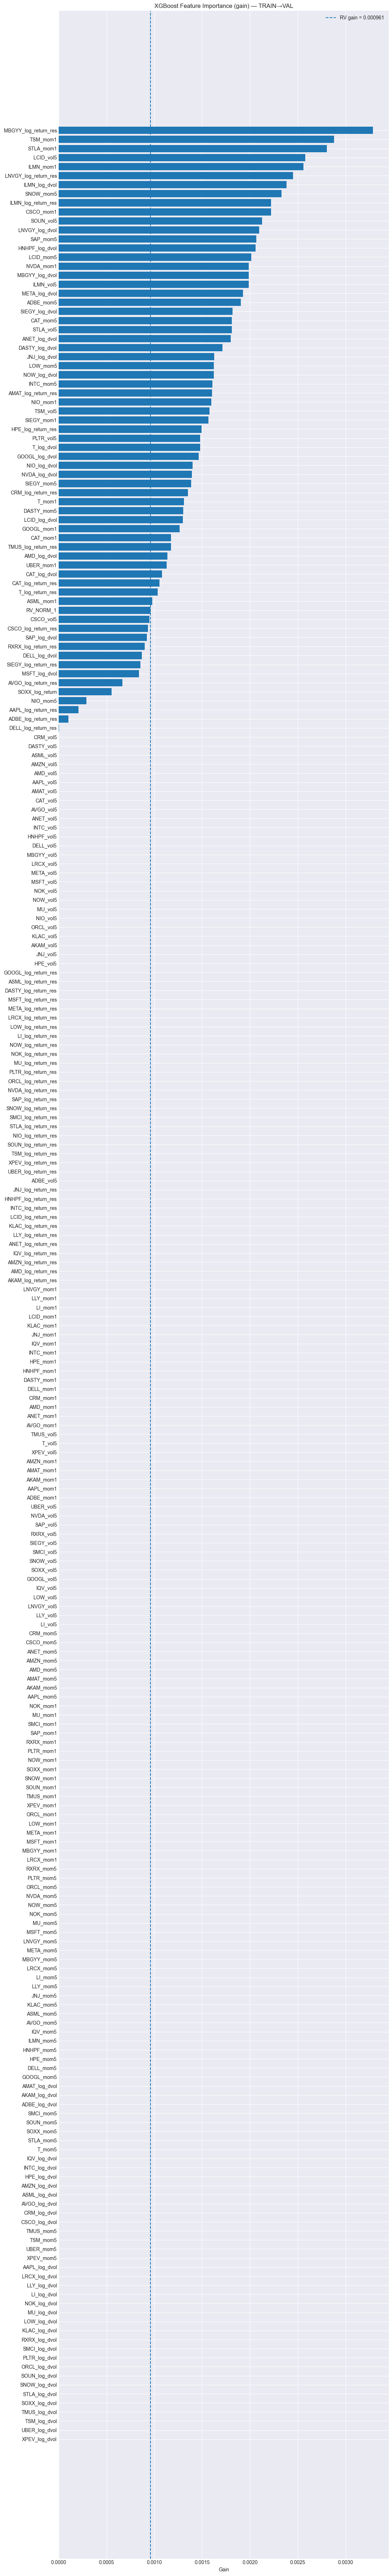

In [25]:
# =========================================
# XGBoost Feature Screening vs Random RVs
# TRAIN → VAL only (no TEST, no predictions)
# =========================================
# Uses gain importance; RV threshold = max gain among RV_NORM_1..K
# Deterministic: no subsampling, fixed seed.

import numpy as np, pandas as pd
from pathlib import Path

# ---- Safe import XGBoost ----
try:
    import xgboost as xgb
except Exception as e:
    raise ImportError(f"XGBoost is required for this block: {e}")

# -----------------------------
# 1) Define fixed TRAIN / VAL splits
# -----------------------------
dates = X_y.index
first_train_start = dates.min()
train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
val_end_date = train_end_start = train_end_date + VAL_OFFSET

train_df_raw = X_y.loc[first_train_start:train_end_date]
val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]

print(
    f"[INFO] Feature-screening splits | "
    f"Train: {train_df_raw.index.min().date()}→{train_df_raw.index.max().date()} ({len(train_df_raw)}) | "
    f"Val: {val_df_raw.index.min().date()}→{val_df_raw.index.max().date()} ({len(val_df_raw)})"
)

if train_df_raw.empty or val_df_raw.empty:
    raise ValueError("[ERROR] Empty TRAIN or VAL split for feature screening.")

# -----------------------------
# 2) Residualize peers using TRAIN betas; build design matrices
# -----------------------------
print("[INFO] Calculating TRAIN betas for residualization...")
betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)

X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

# --- residualized features: ctrl (raw) + peers that actually exist as *_res ---
resid_feature_cols = []
if CTRL_COL in X_train_res.columns:
    resid_feature_cols.append(CTRL_COL)

resid_feature_cols += [f"{p}_res" for p in USE_PEERS if f"{p}_res" in X_train_res.columns]

print(f"[INFO] Residualized base features for XGB ({len(resid_feature_cols)}):")
print(resid_feature_cols)

# --- ALL non-peer / non-control style features (same logic as Ridge/Lasso/ENet) ---
core_peer_set = set(USE_PEERS) | {CTRL_COL}
style_candidates = [
    c for c in FEATURE_COLS if (c not in core_peer_set) and (c != LABEL_COL) and (c in train_df_raw.columns)
]

print(f"[INFO] Non-return / style features for XGB ({len(style_candidates)}):")
print(style_candidates)

# full design = residualized peers (+ control) + style features
Xtr_full = pd.concat([X_train_res[resid_feature_cols], train_df_raw[style_candidates]], axis=1)
Xva_full = pd.concat([X_val_res[resid_feature_cols], val_df_raw[style_candidates]], axis=1)

print(f"[INFO] XGB Xtr_full has {Xtr_full.shape[1]} columns.")

# targets (TRAIN for fitting; VAL for early stopping metric)
ytr = train_df_raw[LABEL_COL].rename("y").astype(float)
yva = val_df_raw[LABEL_COL].rename("y").astype(float)

# -----------------------------
# 3) Align & drop NaNs
# -----------------------------
train_fit_df = Xtr_full.join(ytr).dropna()
val_fit_df = Xva_full.join(yva).dropna()
if train_fit_df.empty or val_fit_df.empty:
    raise ValueError("[ERROR] TRAIN or VAL empty after NaN drop during feature screening.")

Xtr, ytr = train_fit_df.drop(columns=["y"]), train_fit_df["y"]
Xva, yva = val_fit_df.drop(columns=["y"]), val_fit_df["y"]

# -----------------------------
# 4) Inject K independent standard normal RVs (deterministic)
# -----------------------------
SEED_XGB_RV = 1337
K_RV = 1
rng = np.random.default_rng(SEED_XGB_RV)

Xtr = Xtr.copy()
Xva = Xva.copy()
for k in range(1, K_RV + 1):
    Xtr[f"RV_NORM_{k}"] = rng.standard_normal(len(Xtr))
    Xva[f"RV_NORM_{k}"] = rng.standard_normal(len(Xva))  # independent VAL draws

# -----------------------------
# 5) Train XGBoost on TRAIN with VAL early stopping (RMSE)
# -----------------------------
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.06,
    "max_depth": 4,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "reg_lambda": 1.0,
    "nthread": 1,
    "seed": SEED_XGB_RV,
}
num_round = 1500
es_rounds = 100
callbacks = [
    xgb.callback.EarlyStopping(rounds=es_rounds, save_best=True, maximize=False, data_name="val", metric_name="rmse")
]

dtr = xgb.DMatrix(Xtr.values, label=ytr.values, feature_names=Xtr.columns.tolist())
dva = xgb.DMatrix(Xva.values, label=yva.values, feature_names=Xva.columns.tolist())

booster = xgb.train(
    params,
    dtr,
    num_boost_round=num_round,
    evals=[(dtr, "train"), (dva, "val")],
    callbacks=callbacks,
    verbose_eval=False,
)

print(f"[INFO] XGB early-stopped at {booster.best_iteration+1} rounds " f"with best VAL RMSE={booster.best_score:.6g}")

# -----------------------------
# 6) Gain-based importance & RV threshold (nonzero)
# -----------------------------
gain_dict = booster.get_score(importance_type="gain")
all_feats = Xtr.columns.tolist()
imp_gain = pd.Series({f: float(gain_dict.get(f, 0.0)) for f in all_feats}, name="gain")

rv_cols = [c for c in all_feats if c.startswith("RV_NORM_")]
rv_gain = float(imp_gain[rv_cols].max()) if rv_cols else 0.0
if rv_gain <= 0.0:
    rv_gain = 1e-12

REMOVE_FEATURES_XGB = sorted([f for f, g in imp_gain.items() if f not in rv_cols and g < rv_gain])
KEEP_FEATURES_XGB = sorted([f for f in all_feats if f not in rv_cols and f not in REMOVE_FEATURES_XGB])

print("\n[INFO] RV threshold (max gain across RVs): {:.6g}".format(rv_gain))
print("[INFO] Features to REMOVE (gain < RV):", REMOVE_FEATURES_XGB if REMOVE_FEATURES_XGB else "[None]")
print("\n[INFO] Features to KEEP (≥ RV):", KEEP_FEATURES_XGB)

# -----------------------------
# 7) Save AND SHOW importance plot
# -----------------------------
import matplotlib.pyplot as plt

imp_sorted = imp_gain.sort_values(ascending=False)

plt.figure(figsize=(11, max(4, len(imp_sorted) * 0.28)))
plt.barh(imp_sorted.index, imp_sorted.values)
plt.gca().invert_yaxis()
plt.axvline(rv_gain, linestyle="--", linewidth=1.5, label=f"RV gain = {rv_gain:.3g}")
plt.title("XGBoost Feature Importance (gain) — TRAIN→VAL")
plt.xlabel("Gain")
plt.legend()
plt.tight_layout()

outp = RESULTS_DIR / "xgb_feature_importance_gain_train_val.png"
plt.savefig(outp)
print(f"[INFO] Saved XGB gain-importance plot to {outp}")
plt.show()

In [26]:
# =========================================
# XGBoost (Selected Features) — Fixed Forward
# Train -> Val (tune) -> Test (evaluate), then register results
# =========================================
# Prereqs assumed in scope:
#   X_y, LABEL_COL, TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET,
#   CTRL_COL, USE_PEERS, calculate_betas, apply_resid_slice,
#   RESULTS_DIR (Path), ONE_WAY (0.0), register_results()

import numpy as np, pandas as pd
from itertools import product

# ---- Import XGBoost safely ----
try:
    import xgboost as xgb
except Exception as e:
    raise ImportError(f"XGBoost is required: {e}")

# ---- Your final chosen features (from RV screen) ----
SELECTED_XGB_FEATURES = [
    "ADBE_mom5",
    "AMAT_log_return_res",
    "AMD_log_dvol",
    "ANET_log_dvol",
    "ASML_mom1",
    "CAT_log_dvol",
    "CAT_log_return_res",
    "CAT_mom1",
    "CAT_mom5",
    "CRM_log_return_res",
    "CSCO_mom1",
    "DASTY_log_dvol",
    "DASTY_mom5",
    "GOOGL_log_dvol",
    "GOOGL_mom1",
    "HNHPF_log_dvol",
    "HPE_log_return_res",
    "ILMN_log_dvol",
    "ILMN_log_return_res",
    "ILMN_mom1",
    "ILMN_vol5",
    "INTC_mom5",
    "JNJ_log_dvol",
    "LCID_log_dvol",
    "LCID_mom5",
    "LCID_vol5",
    "LNVGY_log_dvol",
    "LNVGY_log_return_res",
    "LOW_mom5",
    "MBGYY_log_dvol",
    "MBGYY_log_return_res",
    "META_log_dvol",
    "NIO_log_dvol",
    "NIO_mom1",
    "NOW_log_dvol",
    "NVDA_log_dvol",
    "NVDA_mom1",
    "PLTR_vol5",
    "SAP_mom5",
    "SIEGY_log_dvol",
    "SIEGY_mom1",
    "SIEGY_mom5",
    "SNOW_mom5",
    "SOUN_vol5",
    "STLA_mom1",
    "STLA_vol5",
    "TMUS_log_return_res",
    "TSM_mom1",
    "TSM_vol5",
    "T_log_dvol",
    "T_log_return_res",
    "T_mom1",
    "UBER_mom1",
]

# -----------------------------
# 1) Fixed Train/Val/Test splits
# -----------------------------
dates = X_y.index
first_train_start = dates.min()
train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
val_end_date = train_end_date + VAL_OFFSET
test_end_date = val_end_date + TEST_OFFSET

train_df_raw = X_y.loc[first_train_start:train_end_date]
val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

print(
    f"[INFO] Fixed splits | Train: {train_df_raw.index.min().date()}→{train_df_raw.index.max().date()} ({len(train_df_raw)})"
)
print(
    f"[INFO] Fixed splits | Val  : {val_df_raw.index.min().date()}→{val_df_raw.index.max().date()}   ({len(val_df_raw)})"
)
print(
    f"[INFO] Fixed splits | Test : {test_df_raw.index.min().date()}→{test_df_raw.index.max().date()}  ({len(test_df_raw)})"
)

if train_df_raw.empty or val_df_raw.empty or test_df_raw.empty:
    raise ValueError("[ERROR] One or more fixed splits are empty.")

# -----------------------------
# 2) Residualize ONLY the peers we need; add style features
# -----------------------------
# Which peers are required by the selected residualized columns?
peers_needed = sorted({c[:-4] for c in SELECTED_XGB_FEATURES if c.endswith("_res")})

print(f"[INFO] Peers needed for residuals: {peers_needed}")

# Calculate betas on TRAIN (uses full FEATURE_COLS + USE_PEERS internally)
betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, peers_needed)

# Residualize peers for all splits using TRAIN betas
X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, peers_needed)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, peers_needed)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, peers_needed)

# Style features (pass-through)
style_candidates = ["nvda_vol5", "nvda_mom1", "nvda_mom5", "nvda_log_dvol"]
style_cols_needed = [c for c in SELECTED_XGB_FEATURES if c in style_candidates]


# Build design matrices containing ONLY the selected features
def build_design(res_df, raw_df, selected):
    out = pd.DataFrame(index=res_df.index)
    for c in selected:
        if c.endswith("_res"):
            if c in res_df.columns:
                out[c] = res_df[c]
            else:
                out[c] = np.nan
        else:
            # style feature in raw_df
            if c in raw_df.columns:
                out[c] = raw_df[c]
            else:
                out[c] = np.nan
    return out


X_train_full = build_design(X_train_res, train_df_raw, SELECTED_XGB_FEATURES)
X_val_full = build_design(X_val_res, val_df_raw, SELECTED_XGB_FEATURES)
X_test_full = build_design(X_test_res, test_df_raw, SELECTED_XGB_FEATURES)

# Targets
y_train = train_df_raw[LABEL_COL].rename("y").astype(float)
y_val = val_df_raw[LABEL_COL].rename("y").astype(float)
y_test = test_df_raw[LABEL_COL].rename("y_real").astype(float)

# -----------------------------
# 3) Align & drop NaNs; drop zero-variance columns (TRAIN-only)
# -----------------------------
tr_df = X_train_full.join(y_train).dropna()
va_df = X_val_full.join(y_val).dropna()
te_df = X_test_full.join(y_test).dropna()

if tr_df.empty or va_df.empty or te_df.empty:
    raise ValueError("[ERROR] Empty aligned TRAIN/VAL/TEST after NaN drop.")

# Drop std==0 on TRAIN only (avoid leakage)
std_tr = tr_df.drop(columns=["y"]).std(ddof=1)
keep_cols = std_tr[std_tr > 0].index.tolist()
if len(keep_cols) < len(SELECTED_XGB_FEATURES):
    dropped = sorted(set(SELECTED_XGB_FEATURES) - set(keep_cols))
    print(f"[INFO] Dropping zero-variance on TRAIN: {dropped}")

# Final matrices
Xtr = tr_df[keep_cols]
ytr = tr_df["y"]
Xva = va_df[keep_cols]
yva = va_df["y"]
Xte = te_df[keep_cols]
yte = te_df["y_real"]

# -----------------------------
# 4) Small hyperparam grid with early stopping on VAL
# -----------------------------
SEED_XGB = 202
param_grid = {
    "eta": [0.03, 0.06],
    "max_depth": [3, 4],
    "subsample": [0.9, 1.0],
    "colsample_bytree": [0.9, 1.0],
    "reg_lambda": [0.0, 1.0],
}

dtr = xgb.DMatrix(Xtr.values, label=ytr.values, feature_names=keep_cols)
dva = xgb.DMatrix(Xva.values, label=yva.values, feature_names=keep_cols)

best_rmse, best_params, best_rounds = np.inf, None, None
num_round, es_rounds = 1200, 80

for eta, md, ss, cs, rl in product(*param_grid.values()):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": eta,
        "max_depth": md,
        "subsample": ss,
        "colsample_bytree": cs,
        "reg_lambda": rl,
        "nthread": 4,
        "seed": SEED_XGB,
    }
    callbacks = [
        xgb.callback.EarlyStopping(
            rounds=es_rounds, save_best=True, maximize=False, data_name="val", metric_name="rmse"
        )
    ]
    booster = xgb.train(
        params,
        dtr,
        num_boost_round=num_round,
        evals=[(dtr, "train"), (dva, "val")],
        callbacks=callbacks,
        verbose_eval=False,
    )
    rmse = booster.best_score
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params.copy()
        best_rounds = booster.best_iteration + 1

print(f"[INFO] Best XGB VAL RMSE = {best_rmse:.6g} | rounds={best_rounds} | params={best_params}")

# -----------------------------
# 5) Refit on TRAIN+VAL with best params; predict TEST
# -----------------------------
X_tv = pd.concat([Xtr, Xva], axis=0)
y_tv = pd.concat([ytr, yva], axis=0)

d_tv = xgb.DMatrix(X_tv.values, label=y_tv.values, feature_names=keep_cols)
d_te = xgb.DMatrix(Xte.values, feature_names=keep_cols)

booster_final = xgb.train(best_params, d_tv, num_boost_round=best_rounds, verbose_eval=False)

y_hat = pd.Series(booster_final.predict(d_te), index=yte.index, name="y_hat")
out_xgb_sel = pd.DataFrame({"y_hat": y_hat}).join(yte).dropna()

# Trading rule & PnL
out_xgb_sel["signal"] = np.where(out_xgb_sel["y_hat"] > 0, 1, np.where(out_xgb_sel["y_hat"] < 0, -1, 0))
out_xgb_sel["signal_prev"] = out_xgb_sel["signal"].shift(1).fillna(0)
legs = (out_xgb_sel["signal"] - out_xgb_sel["signal_prev"]).abs()
out_xgb_sel["cost"] = legs * ONE_WAY  # ONE_WAY = 0.0 per brief
out_xgb_sel["pnl"] = out_xgb_sel["signal"] * out_xgb_sel["y_real"] - out_xgb_sel["cost"]
out_xgb_sel.index.name = "date"

print("\n[INFO] Head of test results (XGB_Selected_Feats):")
print(out_xgb_sel.head())

# -----------------------------
# 6) Register results
# -----------------------------
register_results("XGB_Selected_Feats_FixedFWD", out_xgb_sel)

[INFO] Fixed splits | Train: 2023-07-05→2024-07-03 (252)
[INFO] Fixed splits | Val  : 2024-07-05→2025-01-03   (127)
[INFO] Fixed splits | Test : 2025-01-06→2025-06-26  (118)
[INFO] Peers needed for residuals: ['AMAT_log_return', 'CAT_log_return', 'CRM_log_return', 'HPE_log_return', 'ILMN_log_return', 'LNVGY_log_return', 'MBGYY_log_return', 'TMUS_log_return', 'T_log_return']
[INFO] apply_resid_slice: residualized peers (9): ['AMAT_log_return', 'CAT_log_return', 'CRM_log_return', 'HPE_log_return', 'ILMN_log_return', 'LNVGY_log_return', 'MBGYY_log_return', 'TMUS_log_return', 'T_log_return']
[INFO] apply_resid_slice: residualized peers (9): ['AMAT_log_return', 'CAT_log_return', 'CRM_log_return', 'HPE_log_return', 'ILMN_log_return', 'LNVGY_log_return', 'MBGYY_log_return', 'TMUS_log_return', 'T_log_return']
[INFO] apply_resid_slice: residualized peers (9): ['AMAT_log_return', 'CAT_log_return', 'CRM_log_return', 'HPE_log_return', 'ILMN_log_return', 'LNVGY_log_return', 'MBGYY_log_return', 'TMU


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                             net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                           
XGB_Selected_Feats_FixedFWD       0.8026       0.4182      1.9193     -0.1006   
Ridge_FixedFWD_Resid              0.5349       0.4184      1.2784     -0.1006   
Lasso_FixedFWD_Resid             -0.1515       0.4197     -0.3609     -0.1006   
ENet_FixedFWD_Resid              -0.1515       0.4197     -0.3609     -0.1006   

                             bh_ann_vol  bh_sharpe  turnover_legs_per_day  \
model                                                                       
XGB_Selected_Feats_FixedFWD      0.4212    -0.2389                 0.1780   
Ridge_FixedFWD_Resid             0.4212    -0.2389                 0.6186   
Lasso_FixedFWD_Resid             0.4212    -0.2389                 0.0085   
ENet_FixedF

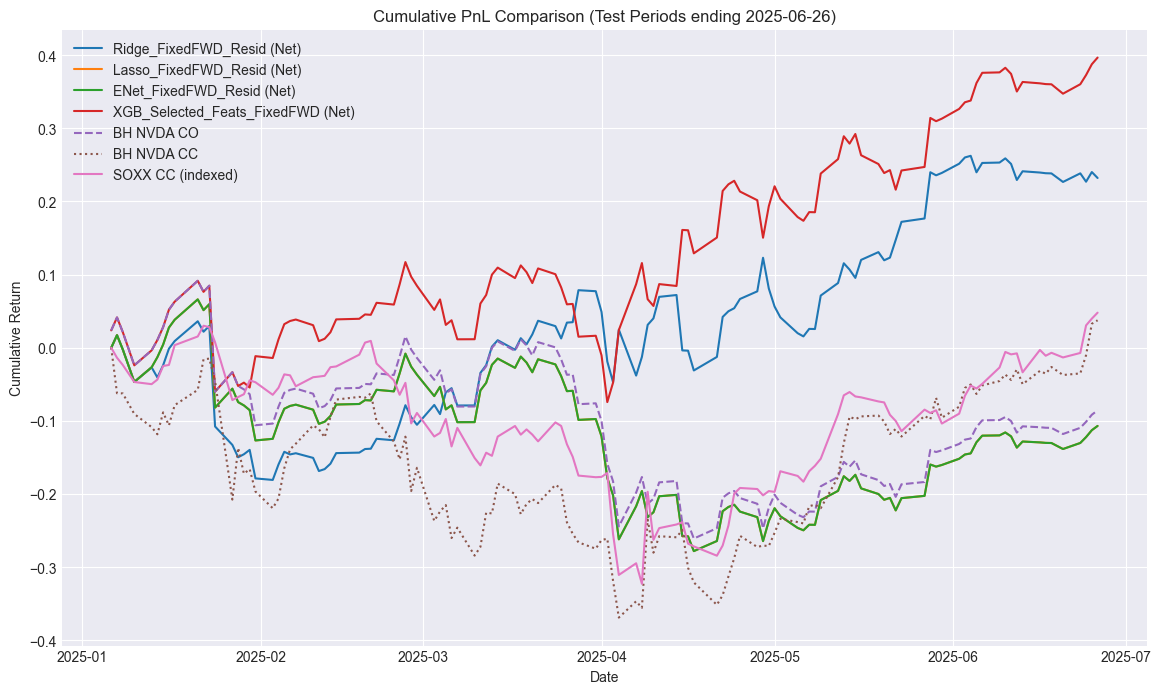

[INFO] XGB_Selected_Feats_FixedFWD test rows: 118


In [27]:
# ============================
# Summary + Plots (All models)
# ============================
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)

# -- Build/print/save summary table --
results_summary = summarize_results(results_store)

if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)

    # Ensure RESULTS_DIR exists (it should from earlier, but just in case)
    try:
        RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"[WARN] Could not confirm/create RESULTS_DIR: {e}")

    # Save summary to CSV (stable name + timestamped snapshot)
    try:
        stable_path = RESULTS_DIR / "model_summary_latest.csv"
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        snapshot_path = RESULTS_DIR / f"model_summary_{ts}.csv"

        results_summary.to_csv(stable_path)  # always overwrite latest
        results_summary.to_csv(snapshot_path)  # keep a dated copy

        print(f"[INFO] Summary saved to:\n  - {stable_path}\n  - {snapshot_path}")
    except Exception as e:
        print(f"[ERROR] Failed to save summary CSVs: {e}")
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0
    ret_windows = []  # record each strategy curve's active window for a common benchmark window

    # Plot strategy cumulative returns (use a copy to avoid mutating originals)
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            df_plot = df.copy()
            if "cum_pnl" not in df_plot.columns:
                df_plot["cum_pnl"] = (1 + df_plot["pnl"].fillna(0)).cumprod() - 1
            curve = df_plot["cum_pnl"].dropna()
            if not curve.empty:
                plt.plot(curve.index, curve.values, label=f"{name} (Net)")
                plot_count += 1
                ret_windows.append((curve.index.min(), curve.index.max()))

    # Pick a representative df carrying y_real for BH NVDA CO
    bh_df_source = None
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df[["y_real"]].copy()
            break

    # Determine COMMON window across strategies for plotting benchmarks
    common_start = None
    common_end = None
    if ret_windows:
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)

    # Plot BH NVDA CO (cumulative) on the common window
    if (
        (bh_df_source is not None)
        and (common_start is not None)
        and (common_end is not None)
        and (common_start < common_end)
    ):
        bh_slice = bh_df_source.loc[(bh_df_source.index >= common_start) & (bh_df_source.index <= common_end)].copy()
        if not bh_slice.empty:
            bh_slice["cum_bh"] = (1 + bh_slice["y_real"].fillna(0)).cumprod() - 1
            if not bh_slice["cum_bh"].isna().all():
                plt.plot(bh_slice.index, bh_slice["cum_bh"], label="BH NVDA CO", linestyle="--")
                plot_count += 1
    elif bh_df_source is not None:
        # Fallback if no overlapping window
        bh_df_source = bh_df_source.copy()
        bh_df_source["cum_bh"] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
        if not bh_df_source["cum_bh"].isna().all():
            plt.plot(bh_df_source.index, bh_df_source["cum_bh"], label="BH NVDA CO", linestyle="--")
            plot_count += 1

    # Add BH NVDA CC and SOXX CC on the same common window (if available)
    if (
        ("adj_close" in locals())
        and isinstance(adj_close, pd.DataFrame)
        and (common_start is not None)
        and (common_end is not None)
        and (common_start < common_end)
    ):
        # BH NVDA CC (indexed)
        if "NVDA" in adj_close.columns:
            px_nvda = adj_close["NVDA"].dropna().sort_index()
            px_nvda = px_nvda.loc[(px_nvda.index >= common_start) & (px_nvda.index <= common_end)]
            if len(px_nvda) >= 2:
                bh_nvda_cc = (px_nvda / px_nvda.iloc[0]) - 1.0
                plt.plot(bh_nvda_cc.index, bh_nvda_cc.values, linestyle=":", label="BH NVDA CC")
        # SOXX CC (indexed)
        if "SOXX" in adj_close.columns:
            px_soxx = adj_close["SOXX"].dropna().sort_index()
            px_soxx = px_soxx.loc[(px_soxx.index >= common_start) & (px_soxx.index <= common_end)]
            if len(px_soxx) >= 2:
                soxx_cc = (px_soxx / px_soxx.iloc[0]) - 1.0
                plt.plot(soxx_cc.index, soxx_cc.values, label="SOXX CC (indexed)")

    if plot_count > 0:
        all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
        all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]
        if all_min_dates and all_max_dates:
            max_date_str = max(all_max_dates).date()
            plt.title(f"Cumulative PnL Comparison (Test Periods ending {max_date_str})")
        else:
            plt.title("Cumulative PnL Comparison")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            plot_filename_cum = "cumulative_pnl_comparison_all.png"
            plt.savefig(RESULTS_DIR / plot_filename_cum)
            print(f"[INFO] Cumulative PnL plot saved to {RESULTS_DIR / plot_filename_cum}")
        except Exception as e:
            print(f"[ERROR] Failed to save cumulative PnL plot: {e}")
        plt.show()
    else:
        print("[INFO] No valid model results found to plot.")

    # Optional: quick counts for your tree models (including the new selected-features run)
    for key in ["XGB_Selected_Feats_FixedFWD", "XGB_FixedFWD_ResidStyle", "LGBM_FixedFWD_ResidStyle"]:
        if key in results_store and not results_store[key].empty:
            print(f"[INFO] {key} test rows: {len(results_store[key])}")
else:
    print("[INFO] results_store is empty. Nothing to plot.")

### Model 5: GARCH(1,1) Regression

In [28]:
# -----------------------------
# Manual fallback feature list for GARCH (when no LASSO selection), using XGBoost
# -----------------------------
GARCH_FALLBACK_FEATURES = [
    "ADBE_mom5",
    "AMAT_log_return_res",
    "AMD_log_dvol",
    "ANET_log_dvol",
    "ASML_mom1",
    "CAT_log_dvol",
    "CAT_log_return_res",
    "CAT_mom1",
    "CAT_mom5",
    "CRM_log_return_res",
    "CSCO_mom1",
    "DASTY_log_dvol",
    "DASTY_mom5",
    "GOOGL_log_dvol",
    "GOOGL_mom1",
    "HNHPF_log_dvol",
    "HPE_log_return_res",
    "ILMN_log_dvol",
    "ILMN_log_return_res",
    "ILMN_mom1",
    "ILMN_vol5",
    "INTC_mom5",
    "JNJ_log_dvol",
    "LCID_log_dvol",
    "LCID_mom5",
    "LCID_vol5",
    "LNVGY_log_dvol",
    "LNVGY_log_return_res",
    "LOW_mom5",
    "MBGYY_log_dvol",
    "MBGYY_log_return_res",
    "META_log_dvol",
    "NIO_log_dvol",
    "NIO_mom1",
    "NOW_log_dvol",
    "NVDA_log_dvol",
    "NVDA_mom1",
    "PLTR_vol5",
    "SAP_mom5",
    "SIEGY_log_dvol",
    "SIEGY_mom1",
    "SIEGY_mom5",
    "SNOW_mom5",
    "SOUN_vol5",
    "STLA_mom1",
    "STLA_vol5",
    "TMUS_log_return_res",
    "TSM_mom1",
    "TSM_vol5",
    "T_log_dvol",
    "T_log_return_res",
    "T_mom1",
    "UBER_mom1",
]

In [29]:
# ================================
# ARX-GARCH with SIMPLE VALIDATION
# ================================
# Assumes upstream:
#   X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, USE_PEERS,
#   TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET,
#   calculate_betas, apply_resid_slice, register_results, ann_stats
#   LASSO_SELECTED_FEATURES or selected_features_lasso (optional)
# =================================

from arch import arch_model
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------
# GARCH config & search grids
# -----------------------------
Z_TAU = 0.3
P_GRID_GARCH = [1, 2]
Q_GRID_GARCH = [1, 2]
M_LAGS_GRID = [0, 1]
DIST_OPTIONS = ["normal"]
ONE_WAY = 0.0  # gross PnL

# -----------------------------
# Fixed time splits (like ENet)
# -----------------------------
if "train_df_raw" not in locals() or "val_df_raw" not in locals() or "test_df_raw" not in locals():
    print("[INFO] Redefining fixed time splits for GARCH (simple validation)...")
    dates = X_y.index
    first_train_start = dates.min()

    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   to {val_df_raw.index.max().date()}   ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  to {test_df_raw.index.max().date()}  ({len(test_df_raw)} days)"
    )

    if train_df_raw.empty or val_df_raw.empty or test_df_raw.empty:
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")
else:
    print("[INFO] Using existing fixed time splits.")

# -----------------------------
# Residualization betas (TRAIN)
# -----------------------------
if "betas_fixed" not in locals():
    print("[INFO] Calculating residualization betas on fixed TRAIN set for GARCH...")
    betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)
else:
    print("[INFO] Using existing fixed betas.")

# -----------------------------
# Apply residualization to splits
# -----------------------------
print("[INFO] Applying residualization to Train / Val / Test for GARCH...")
X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

# Inspect which residual columns actually exist
resid_cols_train = [c for c in X_train_res.columns if c.endswith("_res")]
print(f"[INFO] Residualized peer-return columns in X_train_res ({len(resid_cols_train)}):")
print(resid_cols_train)
print(f"[INFO] Control column present in X_train_res: {CTRL_COL in X_train_res.columns}")

# Residualized feature candidates: *raw* control + only existing peer_res
final_feature_cols = []
# keep raw SOXX_log_return (control), not residualized
if CTRL_COL in X_train_res.columns:
    final_feature_cols.append(CTRL_COL)

# only include residuals that actually exist in X_train_res
final_feature_cols += [f"{p}_res" for p in USE_PEERS if f"{p}_res" in X_train_res.columns]

print(f"[INFO] Residualized feature candidates (pre-filter) " f"({len(final_feature_cols)}): {final_feature_cols}")

# -----------------------------
# Add ALL non-return / non-peer features as style/other
# -----------------------------
peer_set = set(USE_PEERS)
ctrl_col = CTRL_COL

# Any FEATURE_COL that is NOT a peer and NOT the control is treated as a
# non-residualized style/other feature (e.g., vols, mom, dvol for ALL tickers)
style_cols = [c for c in FEATURE_COLS if (c not in peer_set) and (c != ctrl_col) and (c in train_df_raw.columns)]

print(f"[INFO] Non-residualized style/other features ({len(style_cols)}): {style_cols}")

# Build FULL design matrices = [residualized peers (+ctrl)] + [style/other features]
X_train_full = pd.concat([X_train_res[final_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[final_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[final_feature_cols], test_df_raw[style_cols]], axis=1)

print(f"[INFO] X_train_full columns ({len(X_train_full.columns)} total): {list(X_train_full.columns)}")

# Targets
y_train = train_df_raw[LABEL_COL].astype(float)
y_val = val_df_raw[LABEL_COL].astype(float)
y_test = test_df_raw[LABEL_COL].astype(float)

# -----------------------------
# Restrict to LASSO-selected features (if available)
# -----------------------------
_selected = None
if (
    "selected_features_lasso" in locals()
    and isinstance(selected_features_lasso, (list, tuple, pd.Index))
    and len(selected_features_lasso) > 0
):
    _selected = set(selected_features_lasso)
elif (
    "LASSO_SELECTED_FEATURES" in locals()
    and isinstance(LASSO_SELECTED_FEATURES, (list, tuple, pd.Index))
    and len(LASSO_SELECTED_FEATURES) > 0
):
    _selected = set(LASSO_SELECTED_FEATURES)

if _selected is not None:
    # Use LASSO-selected features (intersection with what exists in X_train_full)
    keep_from_lasso = [c for c in X_train_full.columns if c in _selected]
    if not keep_from_lasso:
        print(
            "[WARN] LASSO selection produced no overlapping columns; "
            "falling back to manual GARCH_FALLBACK_FEATURES list."
        )
        keep_from_lasso = [c for c in X_train_full.columns if c in GARCH_FALLBACK_FEATURES]
        if not keep_from_lasso:
            print(
                "[WARN] Manual GARCH_FALLBACK_FEATURES had no overlap; "
                "falling back to all residualized + style features."
            )
            keep_from_lasso = X_train_full.columns.tolist()
else:
    # No LASSO-selected list -> use your hard-coded feature list as fallback
    print("[WARN] No LASSO-selected feature list found; " "using manual GARCH_FALLBACK_FEATURES intersection.")
    keep_from_lasso = [c for c in X_train_full.columns if c in GARCH_FALLBACK_FEATURES]
    if not keep_from_lasso:
        print(
            "[WARN] Manual GARCH_FALLBACK_FEATURES had no overlap; "
            "falling back to all residualized + style features."
        )
        keep_from_lasso = X_train_full.columns.tolist()

X_train_full = X_train_full[keep_from_lasso]
X_val_full = X_val_full.reindex(columns=keep_from_lasso)
X_test_full = X_test_full.reindex(columns=keep_from_lasso)

print(f"[INFO] Features after LASSO/manual selection filter " f"({len(keep_from_lasso)}): {keep_from_lasso}")

# -----------------------------
# Standardization + drop constants
# -----------------------------
sd_train = X_train_full.std(ddof=1)
keep_cols_var = sd_train.index[sd_train > 1e-12].tolist()
dropped_const = sorted(set(X_train_full.columns) - set(keep_cols_var))
if dropped_const:
    print(f"[INFO] Dropping constant features on TRAIN: {dropped_const}")

X_train_full = X_train_full[keep_cols_var]
X_val_full = X_val_full.reindex(columns=keep_cols_var)
X_test_full = X_test_full.reindex(columns=keep_cols_var)

mu_train = X_train_full.mean()
sd_train = X_train_full.std(ddof=1)

X_train_full = (X_train_full - mu_train) / sd_train
X_val_full = (X_val_full - mu_train) / sd_train
X_test_full = (X_test_full - mu_train) / sd_train

full_feature_cols = X_train_full.columns.tolist()
print(f"[INFO] Final feature set used by ARX mean " f"({len(full_feature_cols)}): {full_feature_cols}")


# -----------------------------
# Helper: 1-step variance update
# -----------------------------
def manual_garch11_next_var_from_params(omega, alpha1, beta1, last_resid: float, last_sigma: float):
    return max(float(omega) + float(alpha1) * (last_resid**2) + float(beta1) * (last_sigma**2), 0.0)


# -----------------------------
# Helper: extract mean/var params
# -----------------------------
def _extract_params(result):
    params = result.params

    # --- Mean params ---
    const = float(params.get("Const", 0.0))

    x_coefs = []
    j = 0
    while f"x{j}" in params.index:
        x_coefs.append(float(params[f"x{j}"]))
        j += 1

    ar_coefs = []
    k = 1
    while f"ar.L{k}" in params.index:
        ar_coefs.append(float(params[f"ar.L{k}"]))
        k += 1

    # --- Var params ---
    omega = float(params.get("omega", 0.0))

    alphas = []
    l = 1
    while f"alpha[{l}]" in params.index:
        alphas.append(float(params[f"alpha[{l}]"]))
        l += 1

    betas = []
    m = 1
    while f"beta[{m}]" in params.index:
        betas.append(float(params[f"beta[{m}]"]))
        m += 1

    alpha1 = alphas[0] if len(alphas) > 0 else 0.0
    beta1 = betas[0] if len(betas) > 0 else 0.0

    return {
        "Const": const,
        "x_coefs": x_coefs,
        "ar_coefs": ar_coefs,
        "omega": omega,
        "alpha1": alpha1,
        "beta1": beta1,
    }


# -----------------------------
# Helper: iterative 1-step mean/vol forecast
# -----------------------------
def _iterative_forecast_block(
    y_block: pd.Series,
    X_block: pd.DataFrame,
    params_dict: dict,
    init_resid: float,
    init_sigma: float,
    z_tau: float | None = Z_TAU,
):

    out_rows = []
    last_resid = float(init_resid)
    last_sigma = float(init_sigma)

    ar_coefs = params_dict["ar_coefs"]
    ar_order = len(ar_coefs)
    y_hist = []

    for t, xt in X_block.iterrows():
        xvals = xt.values.astype(float)

        # 1. Mean forecast
        mu_hat = params_dict["Const"]
        if params_dict["x_coefs"]:
            mu_hat += float(np.dot(params_dict["x_coefs"], xvals))

        if ar_order > 0:
            for k in range(1, ar_order + 1):
                y_lag = y_hist[-k] if len(y_hist) >= k else 0.0
                mu_hat += params_dict["ar_coefs"][k - 1] * y_lag

        # 2. Variance forecast
        var_hat = manual_garch11_next_var_from_params(
            params_dict["omega"], params_dict["alpha1"], params_dict["beta1"], last_resid, last_sigma
        )
        sigma_hat = float(np.sqrt(var_hat)) if var_hat >= 0 else np.nan

        y_real = float(y_block.loc[t]) if t in y_block.index else np.nan

        # 3. Signal
        if (z_tau is not None) and (sigma_hat is not None) and (sigma_hat > 1e-9) and (not np.isnan(mu_hat)):
            z = mu_hat / sigma_hat
            sig = 1 if z > z_tau else (-1 if z < -z_tau else 0)
            z_score = z
        elif not np.isnan(mu_hat):
            sig = 1 if mu_hat > 0 else (-1 if mu_hat < 0 else 0)
            z_score = np.nan
        else:
            sig = 0
            z_score = np.nan

        pnl = sig * y_real if not np.isnan(y_real) else 0.0

        out_rows.append(
            {
                "date": t,
                "mu_hat": mu_hat,
                "sigma_hat": sigma_hat,
                "z_score": z_score,
                "y_real": y_real,
                "signal": sig,
                "pnl": pnl,
            }
        )

        if not np.isnan(y_real) and not np.isnan(mu_hat):
            last_resid = y_real - mu_hat
        if not np.isnan(sigma_hat):
            last_sigma = sigma_hat
        if not np.isnan(y_real):
            y_hist.append(y_real)

    df_out = pd.DataFrame.from_records(out_rows).set_index("date").sort_index()
    if not df_out.empty:
        df_out["signal_prev"] = df_out["signal"].shift(1).fillna(0)
        df_out["delta_pos"] = (df_out["signal"] - df_out["signal_prev"]).abs()
    return df_out


# -----------------------------
# SIMPLE VALIDATION: tune (p,q,m,dist)
# -----------------------------
print("\n[INFO] Tuning ARX-GARCH hyperparameters by simple validation (RMSE on μ vs y)...")
best_spec = None
best_rmse = np.inf
best_fit_train = None
best_end_resid = None
best_end_sigma = None
best_features_used = None

Xtr_full = X_train_full.copy()
ytr_full = y_train.copy()
Xva_full = X_val_full.copy()
yva_full = y_val.copy()

tr_df = Xtr_full.join(ytr_full.rename("y")).dropna()
va_df = Xva_full.join(yva_full.rename("y")).dropna()

if tr_df.empty or va_df.empty:
    raise ValueError("[ERROR] TRAIN or VAL is empty after residualization/NaN drop.")

Xtr = tr_df[full_feature_cols].astype(float).values
ytr = tr_df["y"].astype(float).values

Xva = va_df[full_feature_cols].astype(float)
yva = va_df["y"].astype(float)

for dist in DIST_OPTIONS:
    for m in M_LAGS_GRID:
        for p in P_GRID_GARCH:
            for q in Q_GRID_GARCH:
                try:
                    lags_m = int(m) if (m and m > 0) else 0
                    am = arch_model(
                        ytr, mean="ARX", lags=lags_m, x=Xtr, vol="GARCH", p=p, q=q, dist=dist, rescale=False
                    )
                    res_tr = am.fit(disp="off")
                except Exception as e:
                    print(f"[WARN] TRAIN fit failed for (p={p}, q={q}, m={m}, dist={dist}): {e}")
                    continue

                params_d = _extract_params(res_tr)
                last_resid_tr = float(res_tr.resid[-1])
                last_sigma_tr = float(res_tr.conditional_volatility[-1])

                Xva_ordered = Xva[full_feature_cols].copy()

                df_val_fore = _iterative_forecast_block(
                    y_block=yva,
                    X_block=Xva_ordered,
                    params_dict=params_d,
                    init_resid=last_resid_tr,
                    init_sigma=last_sigma_tr,
                    z_tau=None,
                )

                valid = df_val_fore[["mu_hat"]].join(yva.rename("y_real")).dropna()
                if valid.empty:
                    rmse = np.inf
                else:
                    err = valid["y_real"] - valid["mu_hat"]
                    rmse = float(np.sqrt((err**2).mean()))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_spec = {"p": p, "q": q, "m": m, "dist": dist}
                    best_fit_train = res_tr
                    best_end_resid = last_resid_tr
                    best_end_sigma = last_sigma_tr
                    best_features_used = full_feature_cols.copy()

print(f"[INFO] Best spec by VAL RMSE: {best_spec} | RMSE={best_rmse:.6e}")

# -----------------------------
# Final fit on TRAIN+VAL (best spec)
# -----------------------------
print("[INFO] Fitting final ARX-GARCH on TRAIN+VAL with best spec...")
X_tv_res = pd.concat([X_train_full, X_val_full], axis=0)[full_feature_cols]
y_tv = pd.concat([y_train, y_val], axis=0)

fit_df = X_tv_res.join(y_tv.rename("y")).dropna()

if fit_df.empty or (best_spec is None):
    print("[ERROR] Not enough data or no best spec; cannot fit final model.")
    final_garch_fit = None
else:
    Xtv = fit_df[full_feature_cols].astype(float).values
    ytv = fit_df["y"].astype(float).values
    try:
        lags_m = int(best_spec["m"]) if (best_spec["m"] and best_spec["m"] > 0) else 0
        am_final = arch_model(
            ytv,
            mean="ARX",
            lags=lags_m,
            x=Xtv,
            vol="GARCH",
            p=best_spec["p"],
            q=best_spec["q"],
            dist=best_spec["dist"],
            rescale=False,
        )
        final_garch_fit = am_final.fit(disp="off")
        print("[INFO] Final ARX-GARCH model fitted.")
    except Exception as e:
        print(f"[ERROR] Final ARX-GARCH fit failed: {e}")
        final_garch_fit = None

# -----------------------------
# Test: iterative forecast over TEST
# -----------------------------
if (final_garch_fit is not None) and (not X_test_full.empty):
    print("[INFO] Evaluating final ARX-GARCH on TEST (iterative 1-step forecasts)...")

    params_final = _extract_params(final_garch_fit)
    last_resid_fit = float(final_garch_fit.resid[-1])
    last_sigma_fit = float(final_garch_fit.conditional_volatility[-1])

    X_test_predict = X_test_full[full_feature_cols].astype(float).copy()

    df_test_fore = _iterative_forecast_block(
        y_block=y_test.astype(float),
        X_block=X_test_predict,
        params_dict=params_final,
        init_resid=last_resid_fit,
        init_sigma=last_sigma_fit,
        z_tau=Z_TAU,
    )

    if not df_test_fore.empty:
        df_test_fore["signal_prev"] = df_test_fore["signal"].shift(1).fillna(0)
        df_test_fore["cost"] = 0.0
        df_test_fore["pnl"] = df_test_fore["signal"] * df_test_fore["y_real"]

    df_test_fore["hyperparam"] = (
        f"GARCH(p={best_spec['p']}, q={best_spec['q']}), " f"AR lags={best_spec['m']}, dist={best_spec['dist']}"
    )

    wf_garch_fixed_res = df_test_fore.copy()
    wf_garch_fixed_res.index.name = "date"
else:
    print("[WARN] Final GARCH model not trained or TEST set empty. Skipping evaluation.")
    wf_garch_fixed_res = pd.DataFrame()

# -----------------------------
# Register results
# -----------------------------
garch_model_name = "ARXGARCH_FixedFWD_Resid"
register_results(garch_model_name, wf_garch_fixed_res)

if not wf_garch_fixed_res.empty:
    print(f"\n[INFO] {garch_model_name} (head):")
    print(wf_garch_fixed_res.head())
else:
    print(f"[INFO] No results generated for {garch_model_name}.")
print("=" * 50)

[INFO] Using existing fixed time splits.
[INFO] Using existing fixed betas.
[INFO] Applying residualization to Train / Val / Test for GARCH...
[INFO] apply_resid_slice: residualized peers (50): ['AAPL_log_return', 'ADBE_log_return', 'AKAM_log_return', 'AMAT_log_return', 'AMD_log_return', 'AMZN_log_return', 'ANET_log_return', 'ASML_log_return', 'AVGO_log_return', 'CAT_log_return', 'CRM_log_return', 'CSCO_log_return', 'DASTY_log_return', 'DELL_log_return', 'GOOGL_log_return', 'HNHPF_log_return', 'HPE_log_return', 'ILMN_log_return', 'INTC_log_return', 'IQV_log_return', 'JNJ_log_return', 'KLAC_log_return', 'LCID_log_return', 'LI_log_return', 'LLY_log_return', 'LNVGY_log_return', 'LOW_log_return', 'LRCX_log_return', 'MBGYY_log_return', 'META_log_return', 'MSFT_log_return', 'MU_log_return', 'NIO_log_return', 'NOK_log_return', 'NOW_log_return', 'NVDA_log_return', 'ORCL_log_return', 'PLTR_log_return', 'RXRX_log_return', 'SAP_log_return', 'SIEGY_log_return', 'SMCI_log_return', 'SNOW_log_return'


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                             net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                           
XGB_Selected_Feats_FixedFWD       0.8026       0.4182      1.9193     -0.1006   
Ridge_FixedFWD_Resid              0.5349       0.4184      1.2784     -0.1006   
Lasso_FixedFWD_Resid             -0.1515       0.4197     -0.3609     -0.1006   
ENet_FixedFWD_Resid              -0.1515       0.4197     -0.3609     -0.1006   
ARXGARCH_FixedFWD_Resid          -0.2645       0.2978     -0.8883     -0.1006   

                             bh_ann_vol  bh_sharpe  turnover_legs_per_day  \
model                                                                       
XGB_Selected_Feats_FixedFWD      0.4212    -0.2389                 0.1780   
Ridge_FixedFWD_Resid             0.4212    -0.2389                 0.6186   
Lasso_F

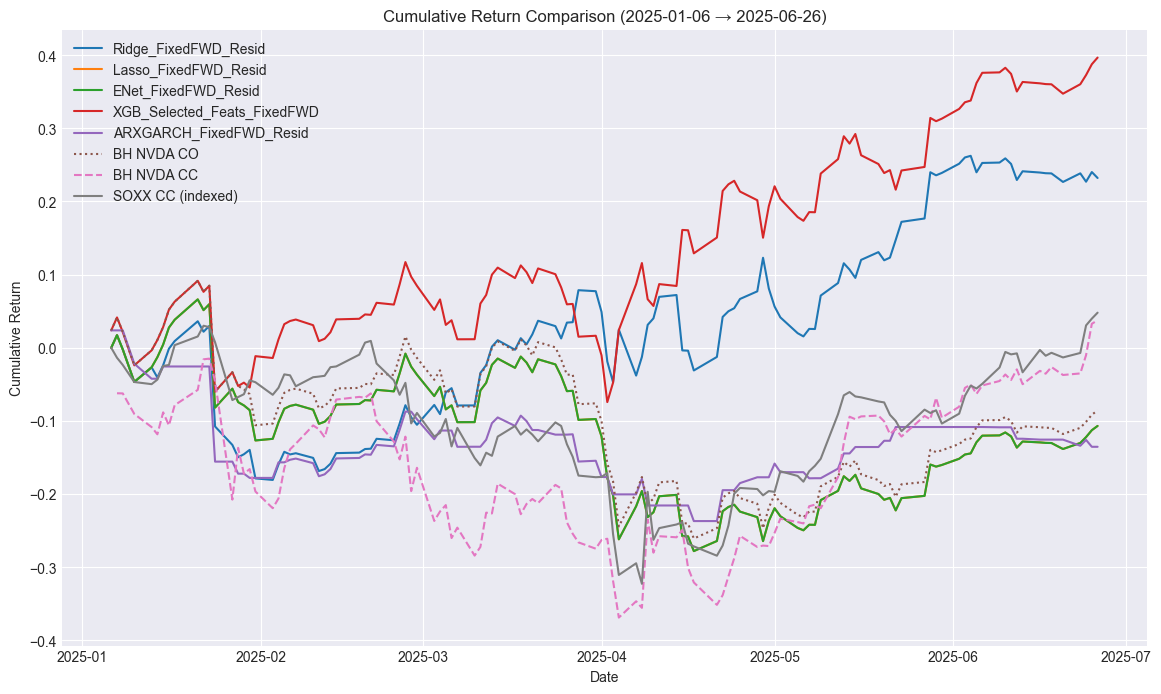

In [30]:
# ================================
# PLOTS (no duplicate benchmarks)
# ================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # 1) Plot all strategy curves
    ret_windows = []
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1
            curve = df["cum_pnl"].dropna()
            if not curve.empty:
                plt.plot(curve.index, curve.values, label=f"{name}")
                plot_count += 1
                ret_windows.append((curve.index.min(), curve.index.max()))

    if plot_count == 0:
        print("[INFO] No strategy returns to plot.")
        plt.close()
    else:
        # 2) Build a COMMON window (intersection) for benchmarks
        #    start = latest of all starts; end = earliest of all ends
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)
        if common_start >= common_end:
            print("[WARN] No overlapping window across models; benchmarks skipped.")
        else:
            # --- BH NVDA CO (from any CO-model's y_real), once
            co_series = None
            for name, df in results_store.items():
                if df is not None and not df.empty and "y_real" in df.columns:
                    s = df["y_real"].dropna()
                    s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                    if len(s) > 0:
                        co_series = s
                        break
            if co_series is not None and len(co_series) > 0:
                bh_co = (1 + co_series).cumprod() - 1
                plt.plot(bh_co.index, bh_co.values, linestyle=":", label="BH NVDA CO")

            # --- BH NVDA CC (from adj_close), once
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
                px = adj_close["NVDA"].dropna().sort_index()
                px = px.loc[(px.index >= common_start) & (px.index <= common_end)]
                if len(px) >= 2:
                    bh_cc = (1 + px.pct_change().dropna()).cumprod() - 1
                    plt.plot(bh_cc.index, bh_cc.values, linestyle="--", label="BH NVDA CC")

            # --- SOXX (indexed), once
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
                soxx = adj_close["SOXX"].dropna().sort_index()
                soxx = soxx.loc[(soxx.index >= common_start) & (soxx.index <= common_end)]
                if len(soxx) >= 2:
                    soxx_norm = (soxx / soxx.iloc[0]) - 1.0
                    plt.plot(soxx_norm.index, soxx_norm.values, label="SOXX CC (indexed)")

        # 3) Finish
        plt.title(f"Cumulative Return Comparison ({common_start.date()} → {common_end.date()})")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            out = RESULTS_DIR / "cumulative_pnl_comparison_no_dupe_benchmarks.png"
            plt.savefig(out)
            print(f"[INFO] Plot saved to {out}")
        except Exception as e:
            print(f"[ERROR] Saving plot failed: {e}")
        plt.show()
else:
    print("[INFO] results_store is empty. Nothing to plot.")

In [31]:
# ===========================================
# METRICS TABLE (single BH NVDA CO/CC & SOXX)
# ===========================================
# This script calculates metrics for all strategies in 'results_store'
# AND for key benchmarks (NVDA CO, NVDA CC, SOXX CC).
#
# Key difference: Benchmarks are calculated *once* over a
# *single common (intersecting) window* of all strategies,
# not duplicated for each strategy.
# ===========================================

import numpy as np, pandas as pd

# --- Configuration & Metric Helper Functions ---

PERIODS_PER_YEAR = 252  # Trading days for annualization
# Define standard column names
RET_COL, SIG_COL, DP_COL = "pnl", "signal", "delta_pos"


# Note: These are terse, one-line metric functions
def _ann_return(r):
    r = pd.Series(r).astype(float).dropna()
    return np.nan if r.empty else r.mean() * PERIODS_PER_YEAR


def _ann_vol(r):
    r = pd.Series(r).astype(float).dropna()
    return np.nan if len(r) <= 1 else r.std(ddof=1) * np.sqrt(PERIODS_PER_YEAR)


def _sharpe(r):
    r = pd.Series(r).astype(float)
    ar = _ann_return(r)
    av = _ann_vol(r)
    # Robust NaN / zero check
    if av is None or np.isnan(av) or av == 0:
        return np.nan
    return ar / av


def _mdd(r):
    """Calculates max drawdown from a return series."""
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return np.nan
    eq = (1 + r).cumprod()  # Calculate cumulative equity curve
    return (eq / eq.cummax() - 1).min()  # (Equity / High-Water Mark) - 1


def _turnover(df):
    """Calculates annualized turnover."""
    # Prefer using the 'delta_pos' column if it's already calculated
    if DP_COL in df.columns:
        dp = pd.Series(df[DP_COL]).astype(float)
    # Fallback: calculate delta position from the 'signal' column
    elif SIG_COL in df.columns:
        sig = pd.Series(df[SIG_COL]).fillna(0).astype(float)
        dp = sig.diff().abs()  # |signal_t - signal_{t-1}|
        if len(sig) > 0:
            dp.iloc[0] = abs(sig.iloc[0])  # Account for the first day's trade
    else:
        return np.nan  # Cannot calculate

    dp = dp.replace([np.inf, -np.inf], np.nan).dropna()  # Clean up
    return np.nan if dp.empty else dp.mean() * PERIODS_PER_YEAR


def _metrics_row(label, r):
    """
    Helper function to compute all metrics for a simple return series
    (e.g., a Buy & Hold benchmark). Hardcodes turnover to 0.0.
    """
    r = pd.Series(r).astype(float).dropna()
    # Return an empty row if no data
    if r.empty:
        return {
            "Model": label,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": 0.0,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }
    # Calculate all metrics
    return {
        "Model": label,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _mdd(r),
        "Ann Turnover": 0.0,
        "Start": r.index.min(),
        "End": r.index.max(),
        "N": r.shape[0],
    }


# --- Main Logic ---
rows = []  # This list will hold all the dictionary-rows for the final table

# 1) Strategy rows + build common window (intersection) for unified benchmarks
windows = []  # This list will store (start, end) tuples for each model
if "results_store" in locals() and results_store:
    # Loop through each strategy in the global registry
    for name, df in results_store.items():
        # Validate data
        if df is None or df.empty or RET_COL not in df.columns:
            continue
        r = pd.Series(df[RET_COL]).astype(float).dropna()
        if r.empty:
            continue

        # Calculate all metrics for the strategy PnL
        rows.append(
            {
                "Model": name,
                "Ann Return": _ann_return(r),
                "Ann Vol": _ann_vol(r),
                "Sharpe": _sharpe(r),
                "Max Drawdown": _mdd(r),
                "Ann Turnover": _turnover(df),  # Use the full DF for turnover calculation
                "Start": r.index.min(),
                "End": r.index.max(),
                "N": r.shape[0],
            }
        )
        # Store this model's test window to find the common period
        windows.append((r.index.min(), r.index.max()))

# 2) Unified benchmarks ONCE using the common (intersection) window
if windows:
    # Find the *intersection* of all test windows:
    common_start = max(s for s, _ in windows)  # The latest start date
    common_end = min(e for _, e in windows)  # The earliest end date

    # Check if a valid overlapping window exists
    if common_start < common_end:

        # --- Benchmark 1: BH NVDA CO (Close-to-Open) ---
        # Get this from the 'y_real' column of any model
        co_series = None
        for _, df in results_store.items():
            if df is not None and not df.empty and "y_real" in df.columns:
                s = df["y_real"].dropna()
                # Slice the series to the common window
                s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                if len(s) > 0:
                    co_series = s
                    break
        if co_series is not None:
            rows.append(_metrics_row("BH NVDA CO", co_series))

        # --- Benchmark 2: BH NVDA CC (Close-to-Close) ---
        # Get this from the global 'adj_close' DataFrame (if it exists)
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
            # Get NVDA prices and slice to the common window
            px = adj_close["NVDA"].dropna().sort_index().loc[common_start:common_end]
            if len(px) >= 2:
                # Use LOG C→C returns for consistency in metrics
                r_cc = np.log(px / px.shift(1)).dropna()
                rows.append(_metrics_row("BH NVDA CC", r_cc))

        # --- Benchmark 3: SOXX CC (Close-to-Close) ---
        # Get this from the global 'adj_close' DataFrame
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
            # Get SOXX prices and slice to the common window
            soxx_px = adj_close["SOXX"].dropna().sort_index().loc[common_start:common_end]
            if len(soxx_px) >= 2:
                # Use LOG C→C returns for consistency in metrics
                soxx_r = np.log(soxx_px / soxx_px.shift(1)).dropna()
                rows.append(_metrics_row("SOXX CC", soxx_r))
    else:
        print("[WARN] No overlapping window across models; unified benchmarks omitted.")

# --- 3. Build and Print Final Table ---
metrics_df = pd.DataFrame(rows)  # Convert list of dicts to DataFrame
if not metrics_df.empty:
    # Define final column order
    cols = ["Model", "Ann Return", "Ann Vol", "Sharpe", "Max Drawdown", "Ann Turnover", "Start", "End", "N"]
    metrics_df = metrics_df[cols]

    # Print formatted table to console
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print("\nMETRICS SUMMARY (Common Window)")
        print(metrics_df.to_string(index=False))  # Use to_string for clean printing

    # Save table to CSV
    try:
        # Assumes RESULTS_DIR is a Path object defined elsewhere
        out_path = RESULTS_DIR / "metrics_summary_no_dupes.csv"
        metrics_df.to_csv(out_path, index=False)
        print(f"[INFO] Saved metrics table to {out_path}")
    except Exception as e:
        print(f"[WARN] Could not save metrics CSV: {e}")
else:
    print("[INFO] No metrics computed; check results_store.")


METRICS SUMMARY (Common Window)
                      Model  Ann Return  Ann Vol  Sharpe  Max Drawdown  Ann Turnover      Start        End   N
       Ridge_FixedFWD_Resid      0.5349   0.4184  1.2784       -0.2093      155.8983 2025-01-06 2025-06-26 118
       Lasso_FixedFWD_Resid     -0.1515   0.4197 -0.3609       -0.3228        2.1356 2025-01-06 2025-06-26 118
        ENet_FixedFWD_Resid     -0.1515   0.4197 -0.3609       -0.3228        2.1356 2025-01-06 2025-06-26 118
XGB_Selected_Feats_FixedFWD      0.8026   0.4182  1.9193       -0.1713       44.8475 2025-01-06 2025-06-26 118
    ARXGARCH_FixedFWD_Resid     -0.2645   0.2978 -0.8883       -0.2546      132.4068 2025-01-06 2025-06-26 118
                 BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
                 BH NVDA CC      0.0795   0.6388  0.1244       -0.3955        0.0000 2025-01-07 2025-06-26 117
                    SOXX CC      0.1010   0.4855  0.2080       -0.3583        0